# Masterskaya_DS20+_Matching

Задача: разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из датасета base.csv. Полученный алгоритм может применяться Заказчиком для рекомендательной системы.

In [1]:
# загружаем сторонние библиотеки
!pip install faiss-cpu

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

## Выгрузка данных

Выгрузим датасеты и проанализируем их.

In [3]:
%%time
# выгружаем датасет
df_base = pd.read_csv('//192.168.2.105/consilio/DFS Folders/Users/s.gayvazov/Мои документы/Практикум/Мастерская_2/base.csv',
                     index_col=0)
# на диск не смог такой большой файл загрузить.

Wall time: 3min 48s


In [4]:
# выведем первые 5 строк датасета
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
# выведем размерность датасета
df_base.shape

(2918139, 72)

In [6]:
# выведем общую информацию по датасету
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


С типами данных всё в порядке. Переходим в выгрузке тренировочного датасета.

In [7]:
%%time
# выгружаем датасет в переменную
df_train = pd.read_csv('//192.168.2.105/consilio/DFS Folders/Users/s.gayvazov/Мои документы/Практикум/Мастерская_2/train.csv',
                       index_col=0)

Wall time: 7.86 s


In [8]:
# выведем первые 5 строк датасета
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [9]:
# выведем размерность датасета
df_train.shape

(100000, 73)

In [10]:
# выведем общую информацию по датасету
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

С типами данных всё в порядке.
Датасеты содержат числовые столбцы с закодированными признаками и столбец id. В датасете df_train так же содержится столбец 'Target', в котором содержится отсылка к id в base наиболее подходящего товара по мнению специалистов.
Можем перейти к обработке данных.

## Обработка данных

Для начала проанализируем пропуски и дубликаты в датасетах. Затем построим гистограммы по столбцам и проанализируем их.

In [11]:
# проверим дубликаты
df_base.duplicated().sum()

0

In [12]:
# проверим дубликаты в тренировочном датасете
df_train.duplicated().sum()

0

Дубликаты отсутствуют. Теперь проверим пропуски

In [13]:
df_base.isna().sum().sum()

0

In [14]:
df_train.isna().sum().sum()

0

Пропуски отсутствуют. Выведим числовое описание данных и гистограммы по столбцам.

In [15]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


In [16]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Построим гистограммы для столбцов датасета df_base

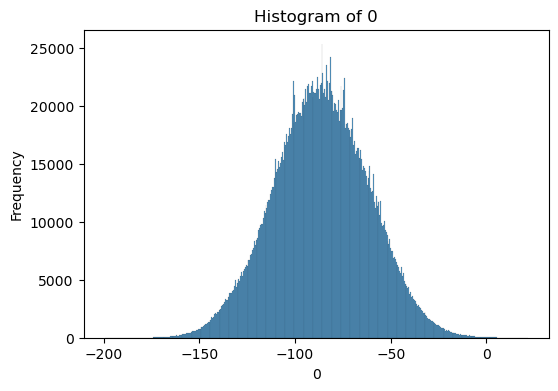

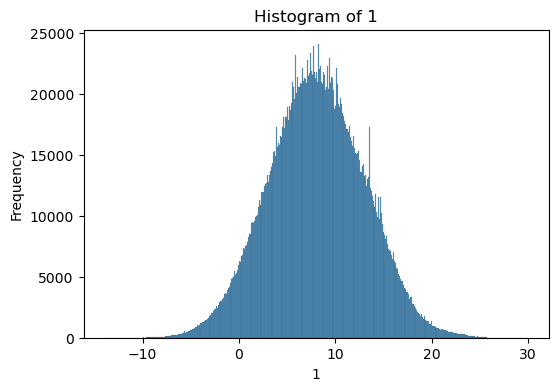

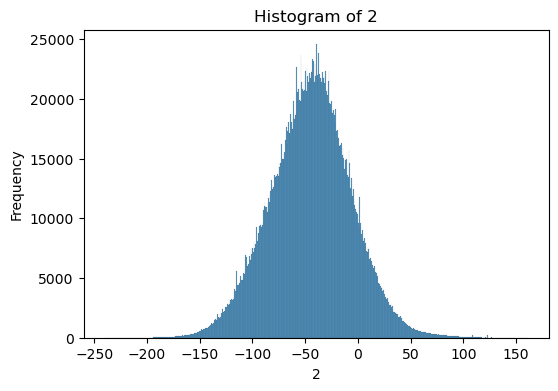

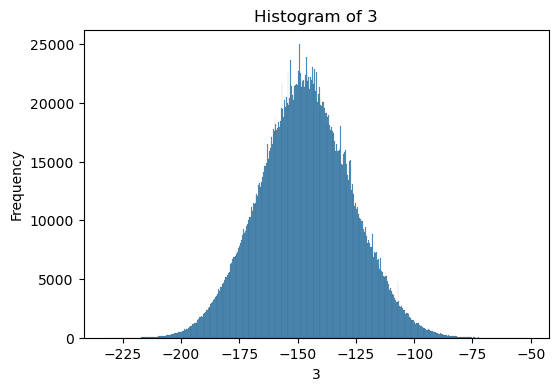

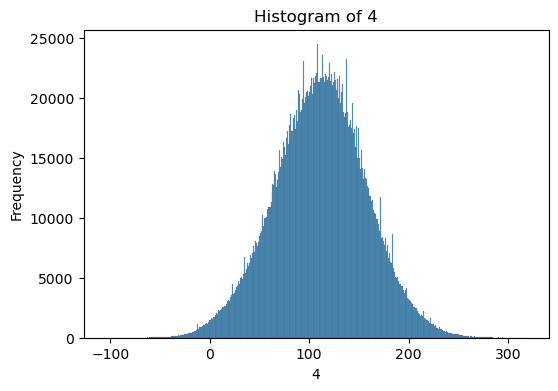

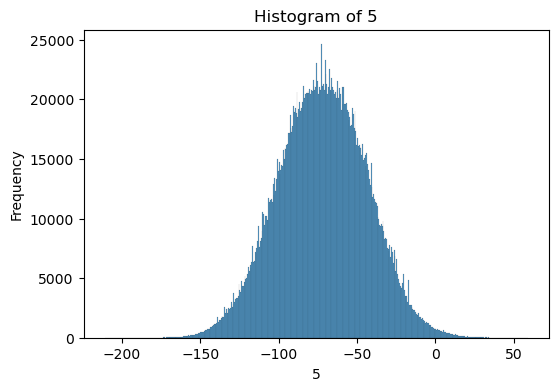

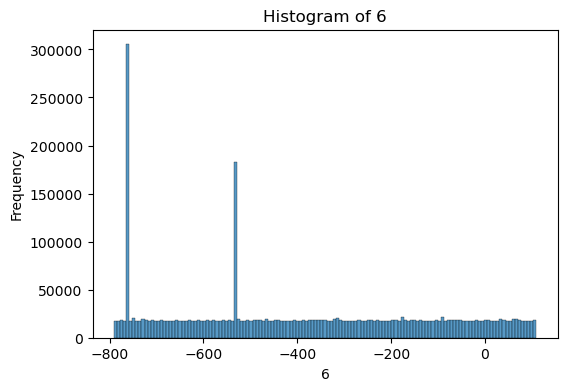

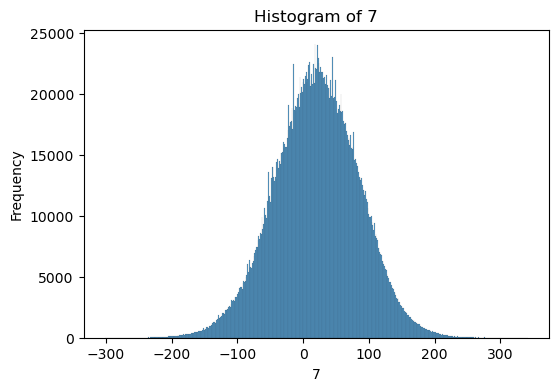

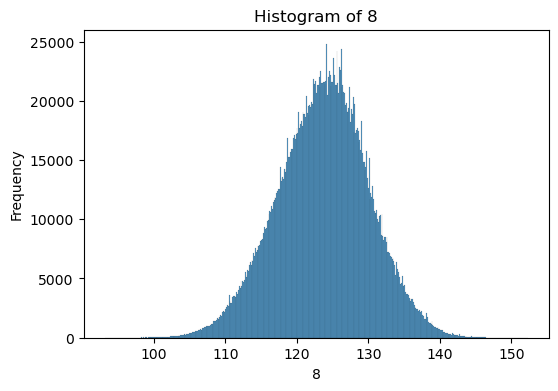

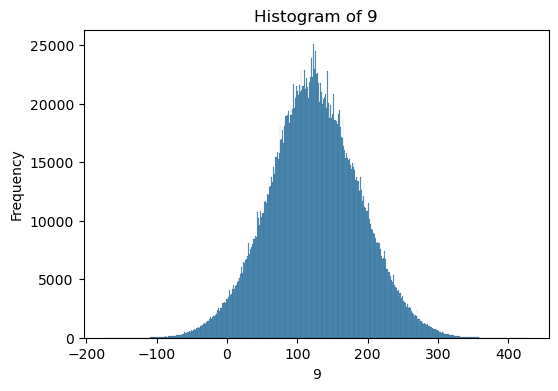

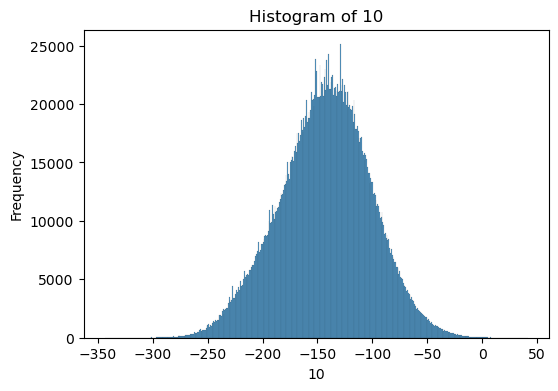

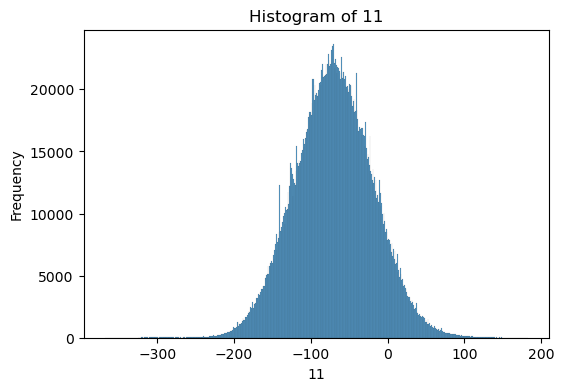

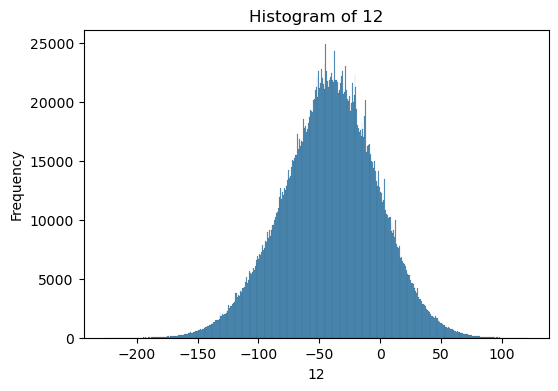

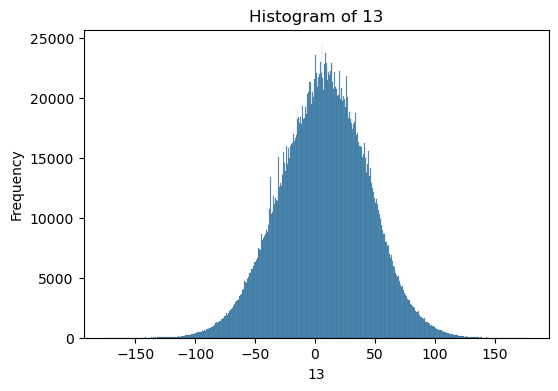

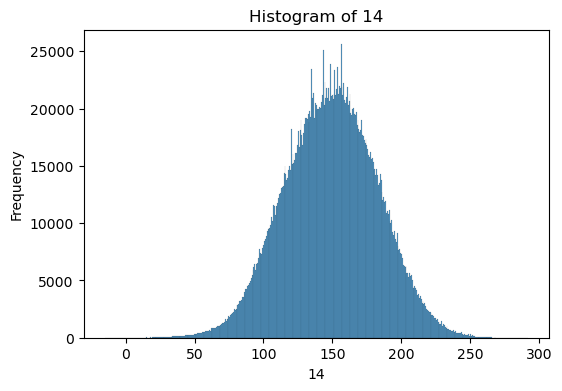

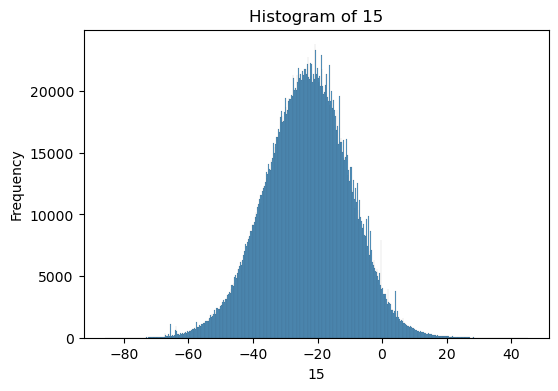

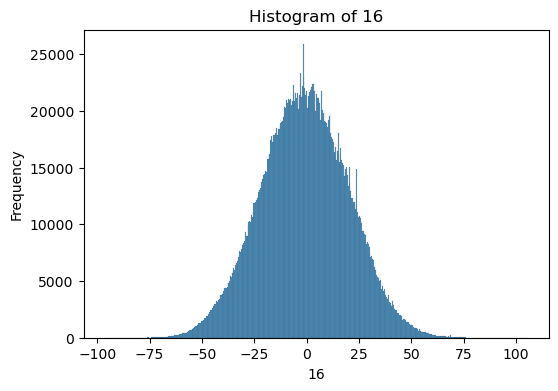

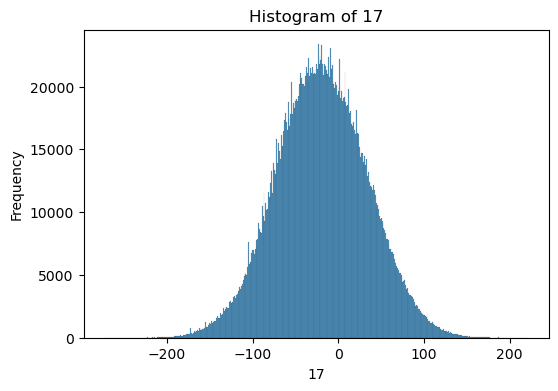

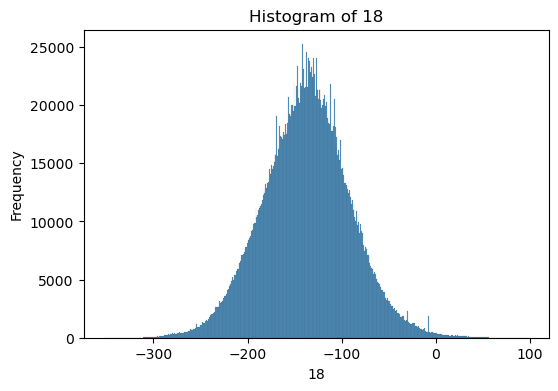

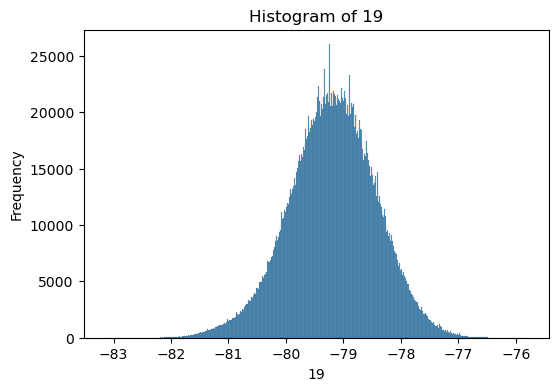

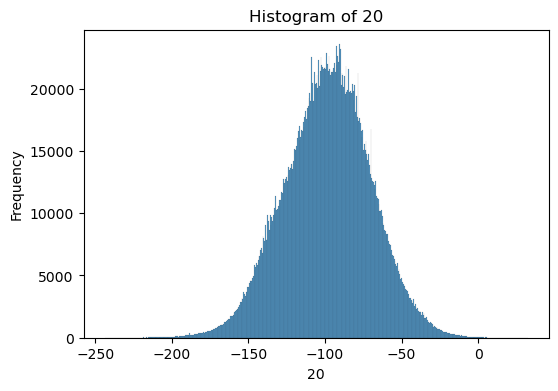

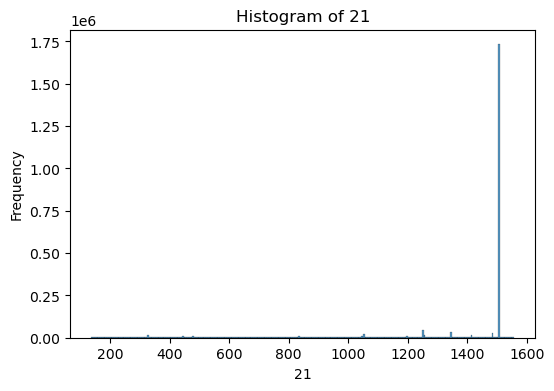

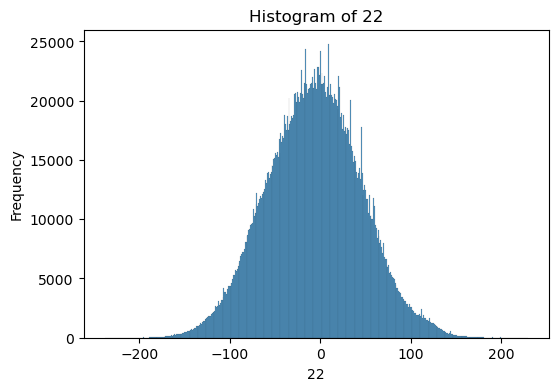

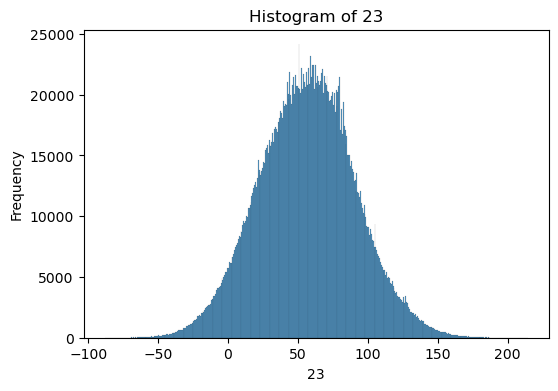

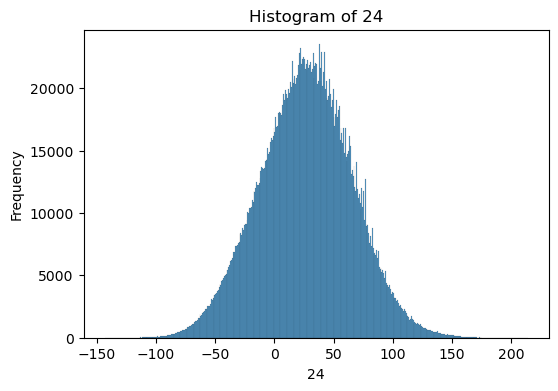

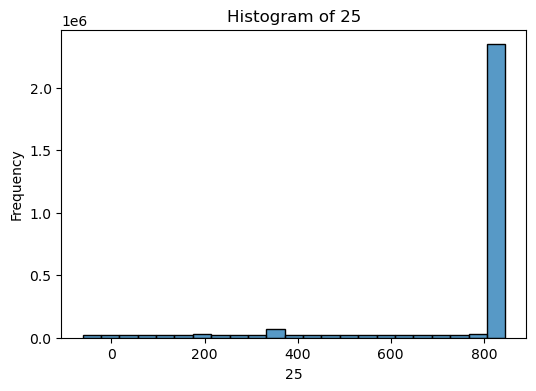

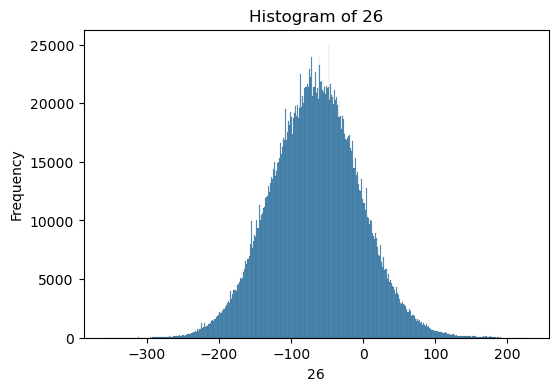

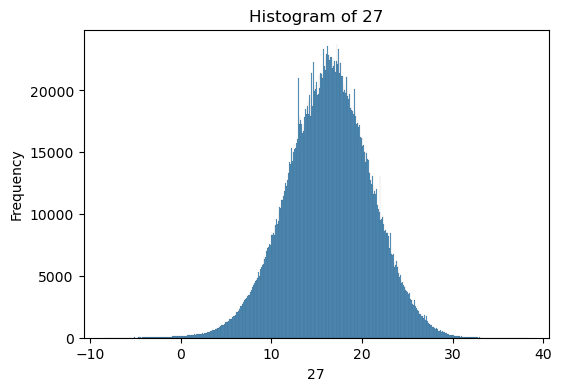

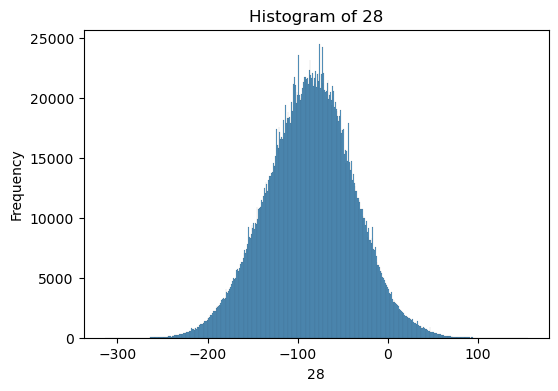

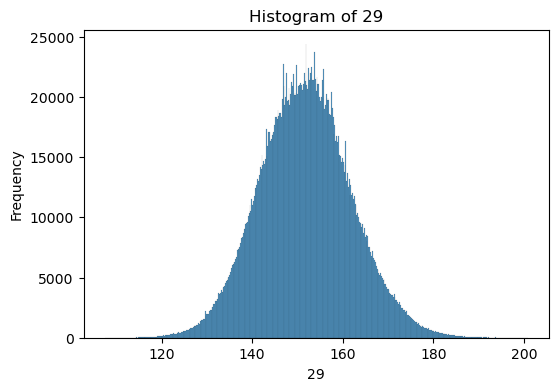

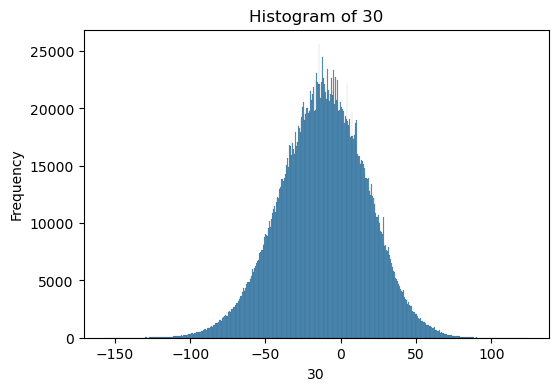

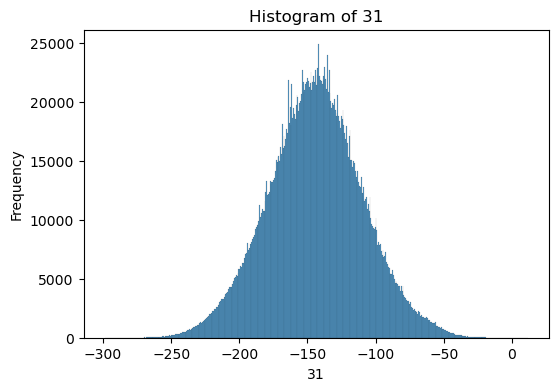

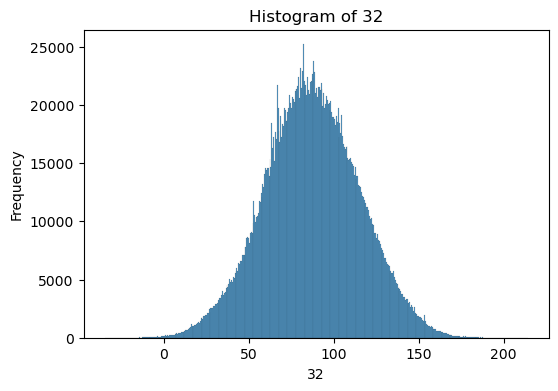

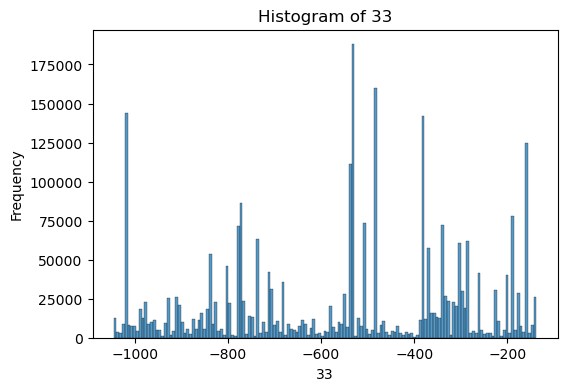

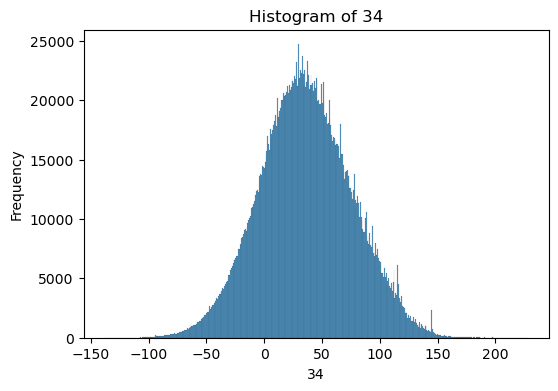

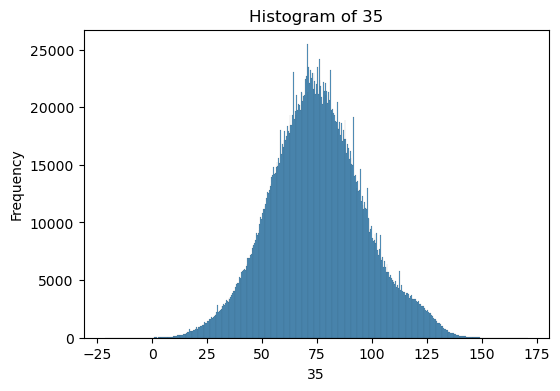

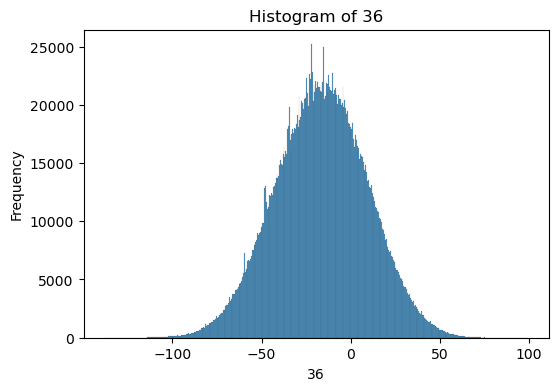

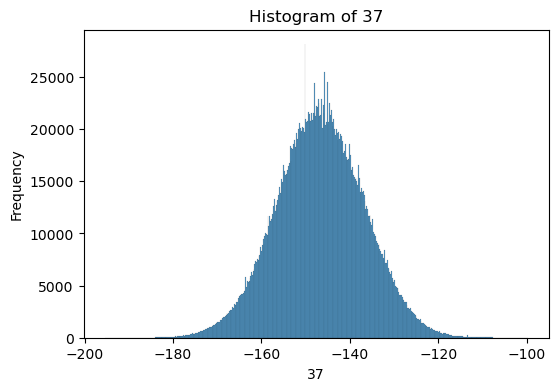

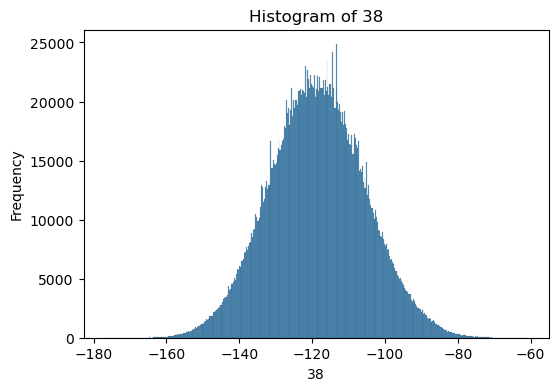

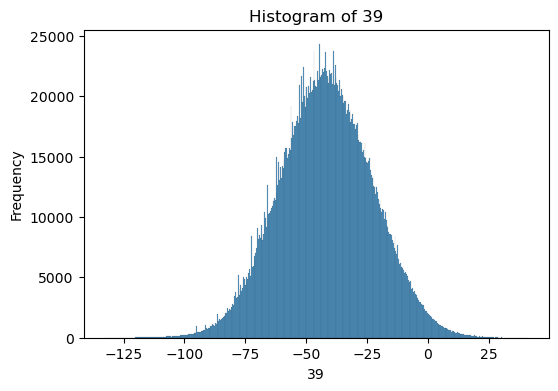

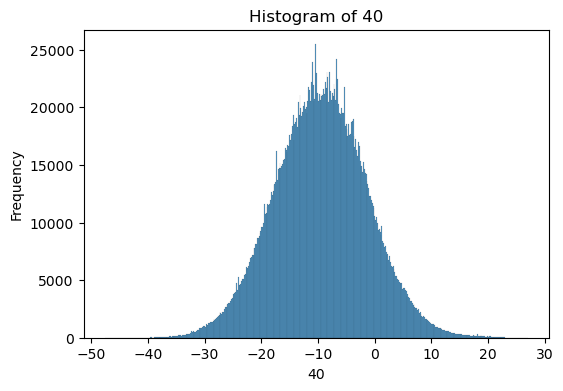

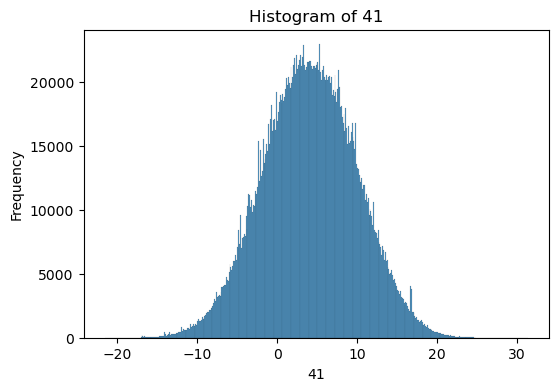

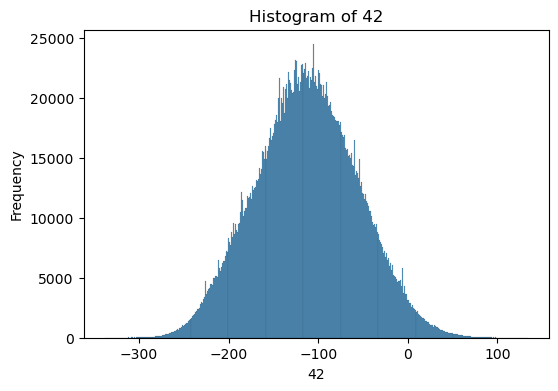

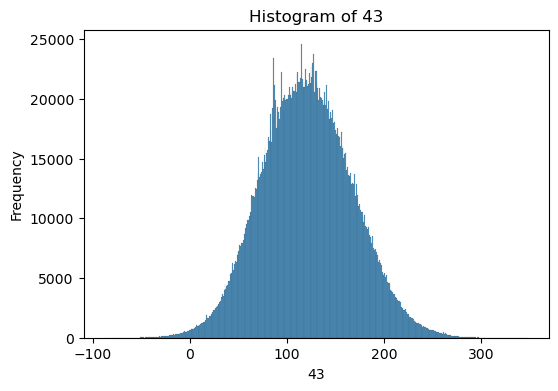

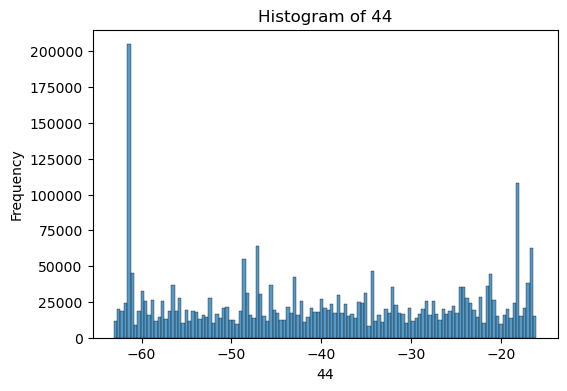

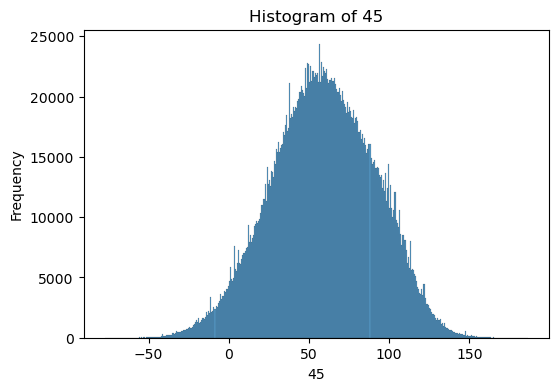

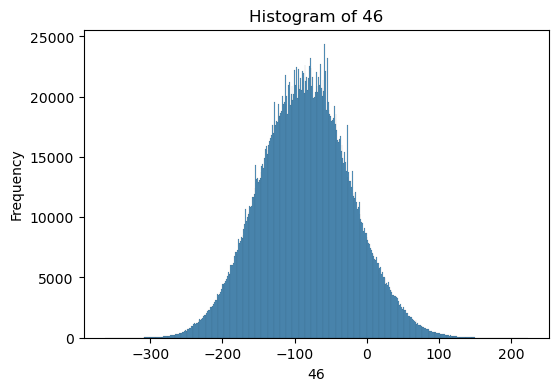

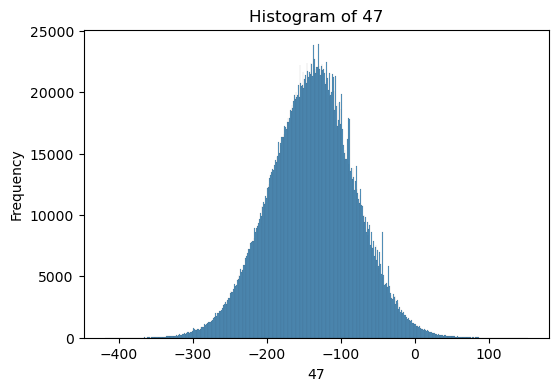

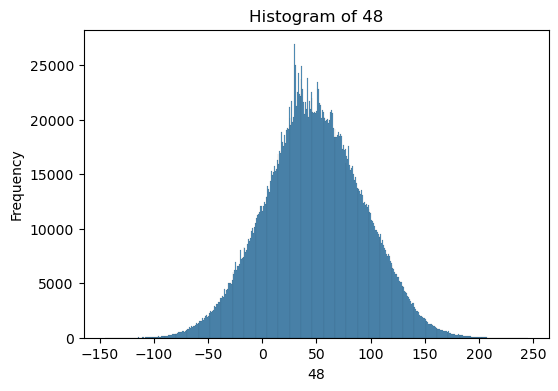

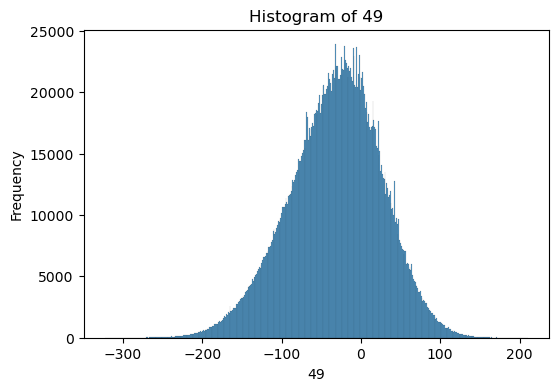

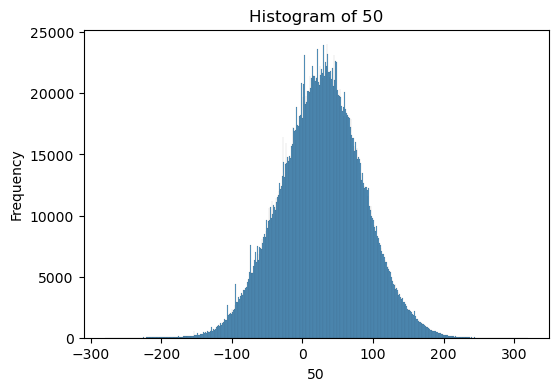

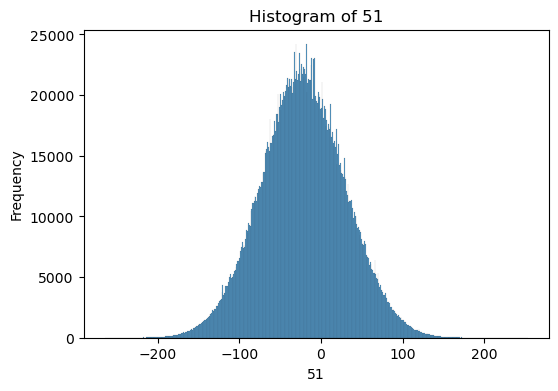

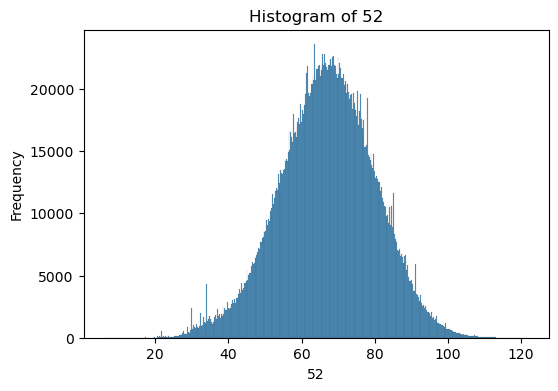

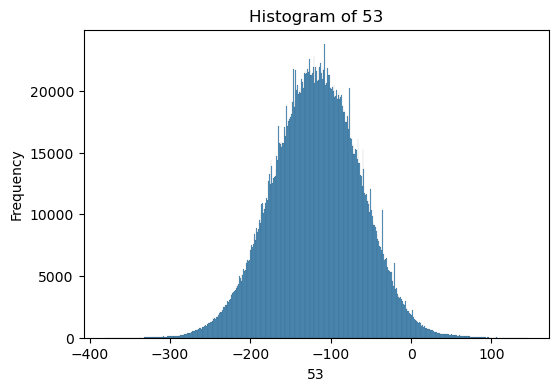

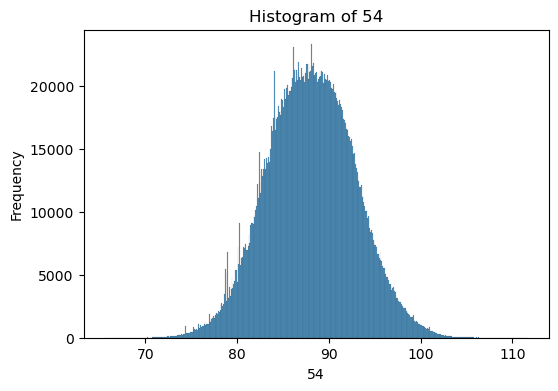

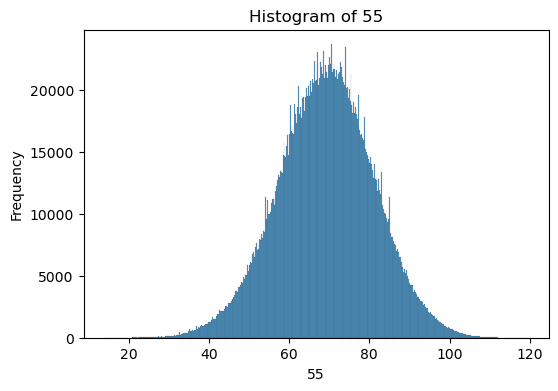

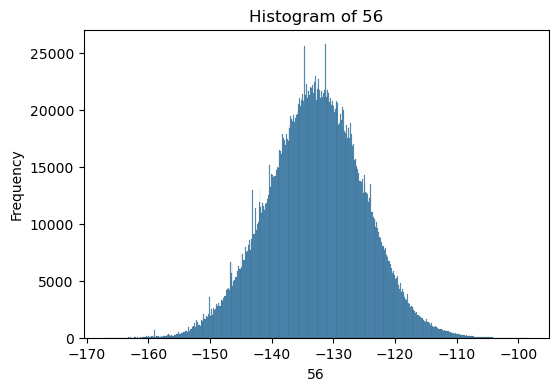

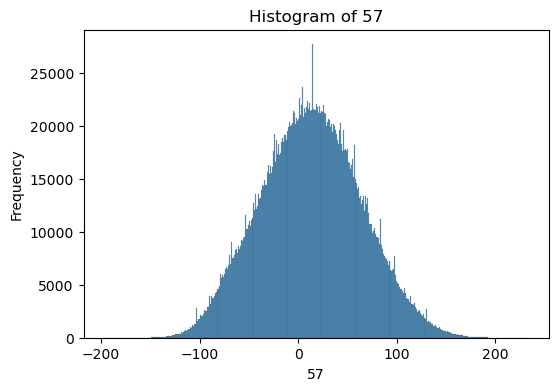

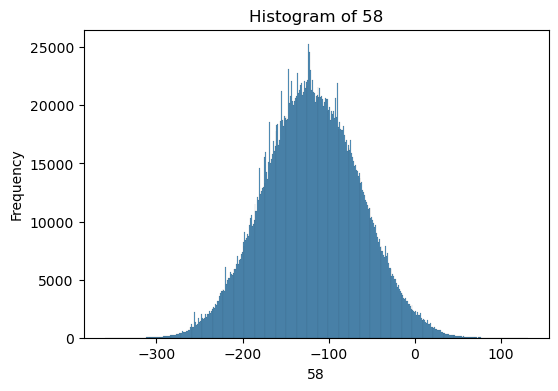

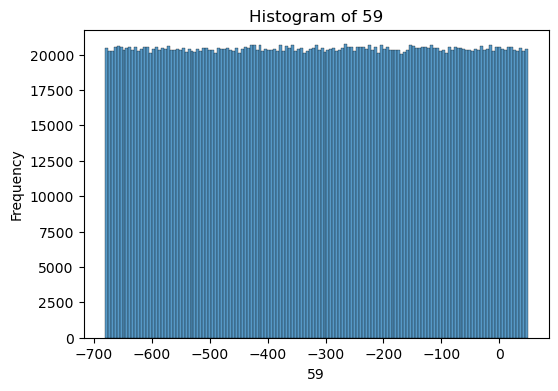

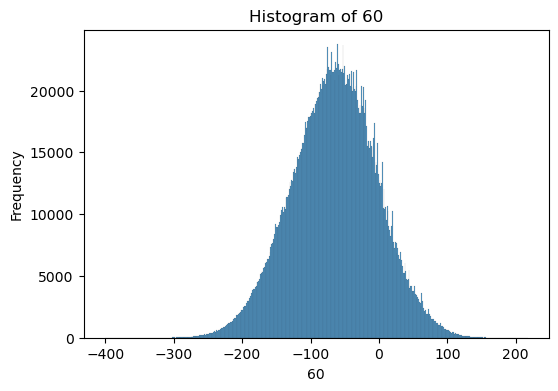

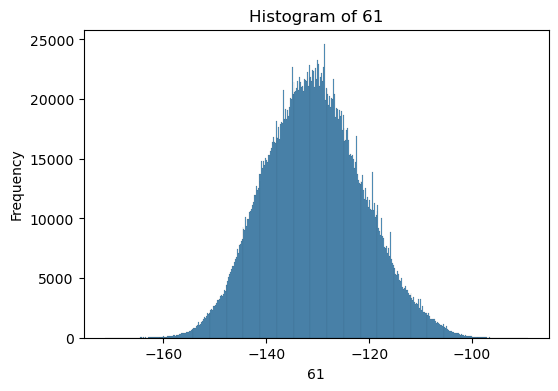

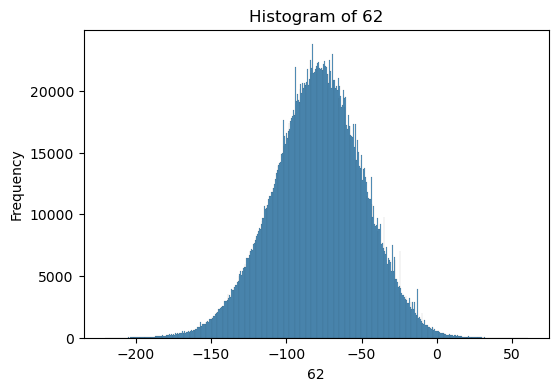

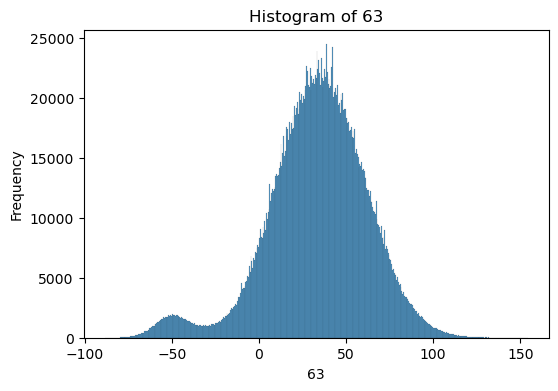

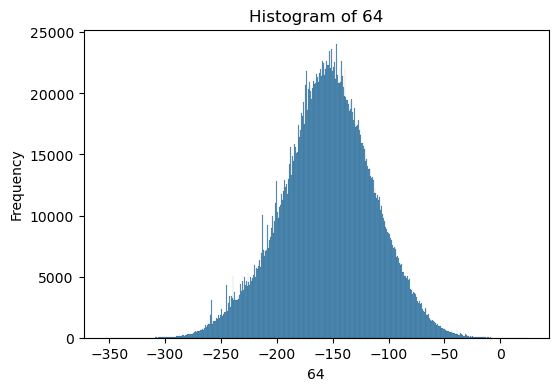

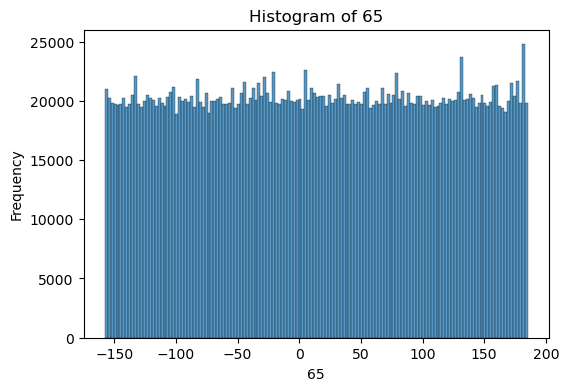

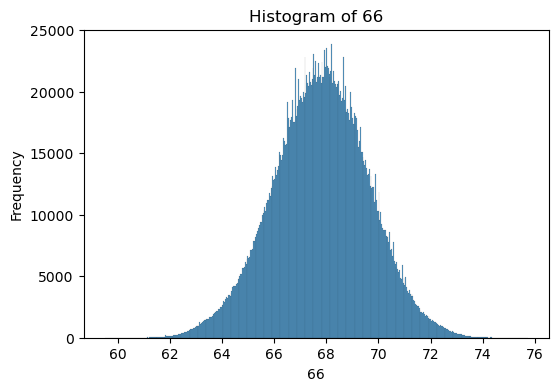

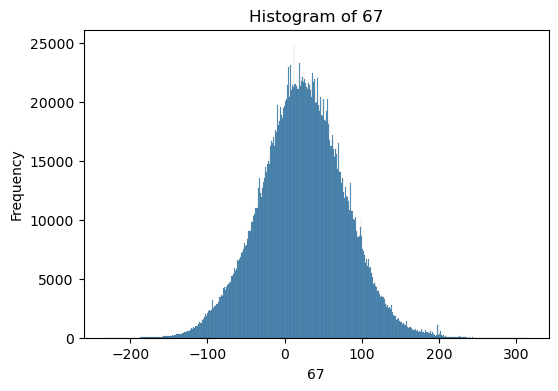

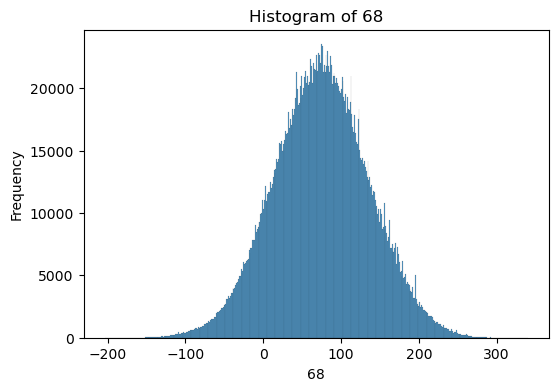

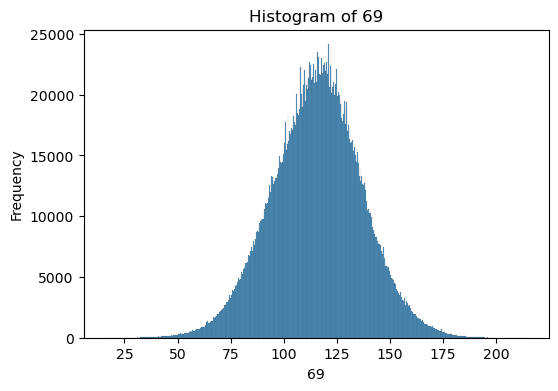

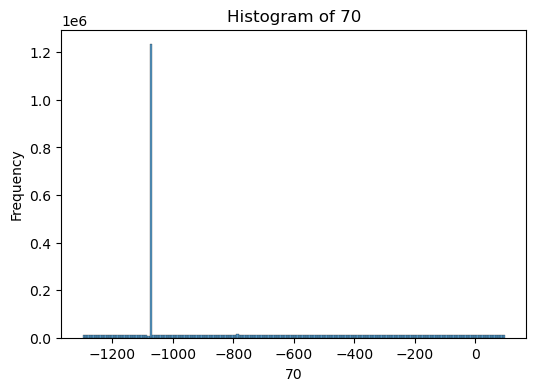

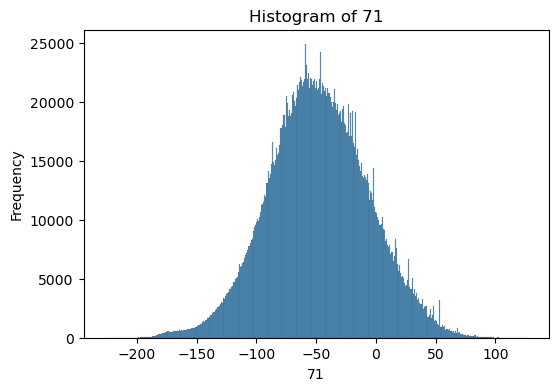

Wall time: 2min 21s


In [17]:
%%time
for column in df_base.columns:
    plt.figure(figsize=(6, 4))  # Задайте размер графика по желанию
    sns.histplot(df_base[column])  # Используйте sns.histplot для построения гистограммы с ядерной оценкой плотности
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Построим гистограммы для столбцов датасета df_train

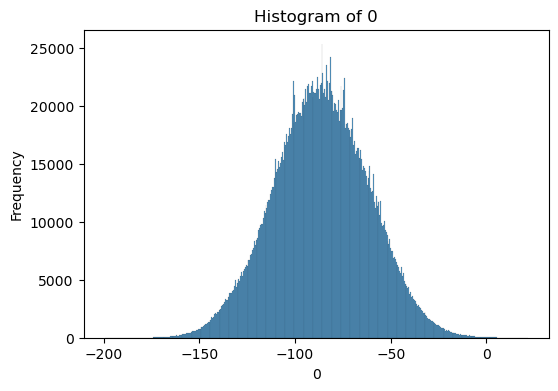

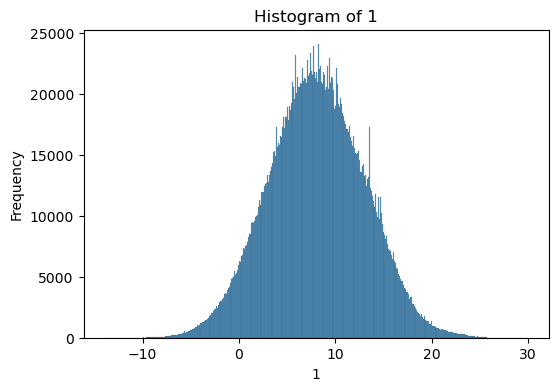

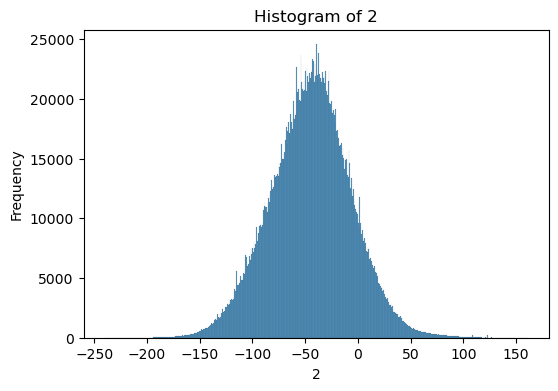

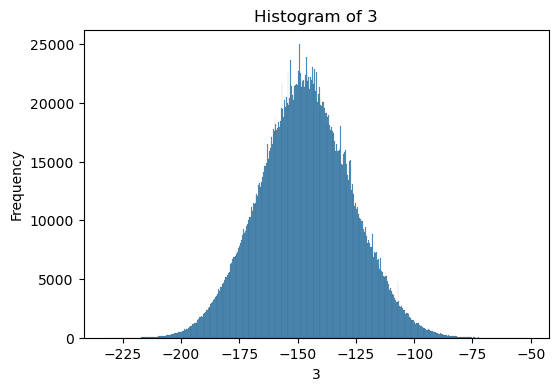

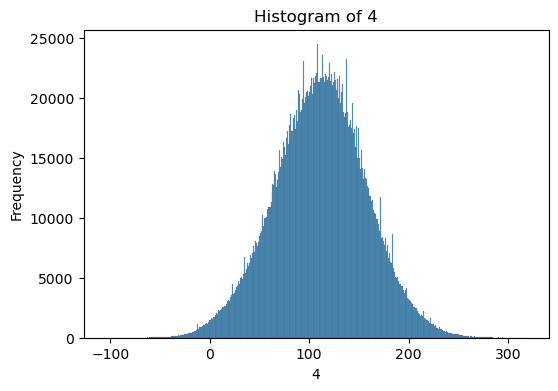

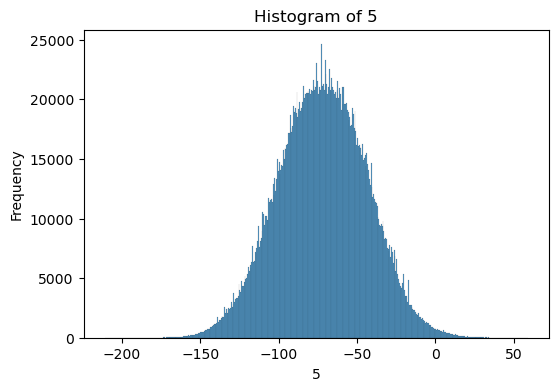

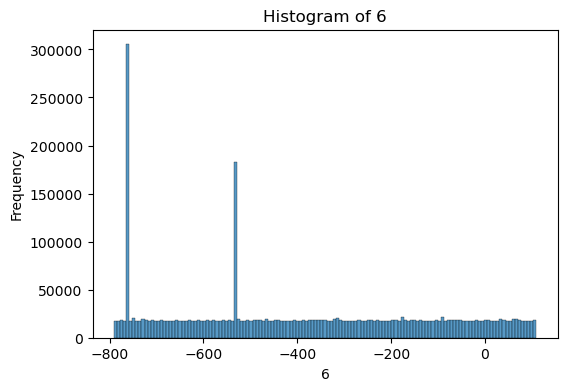

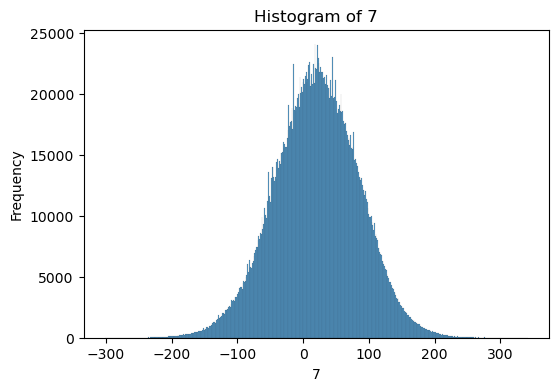

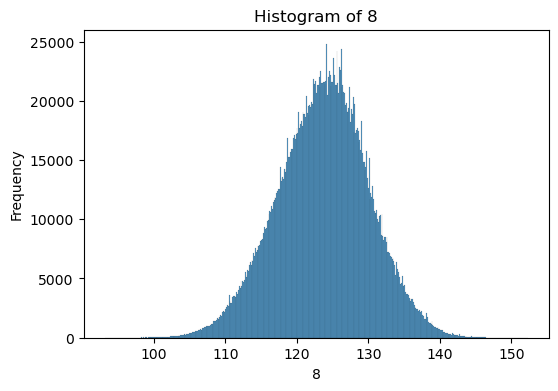

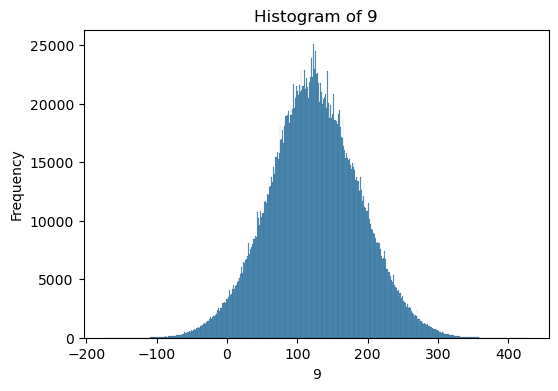

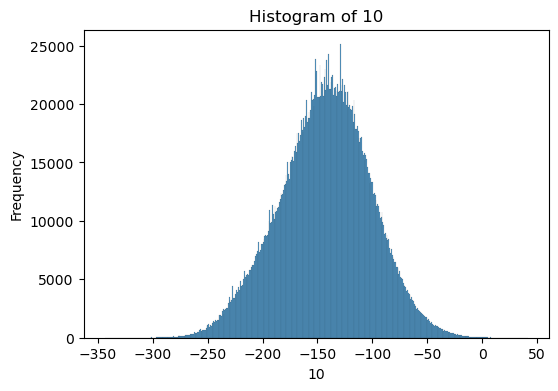

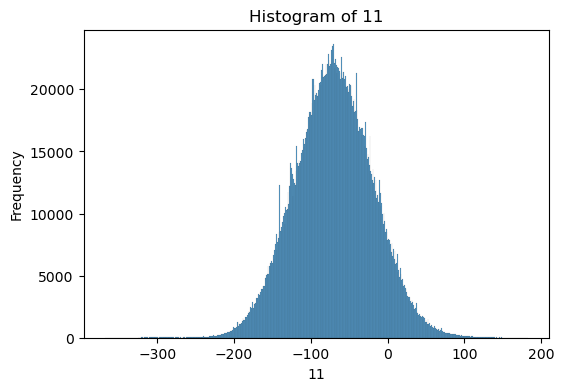

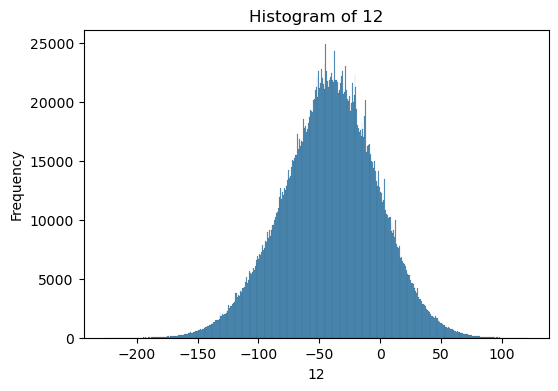

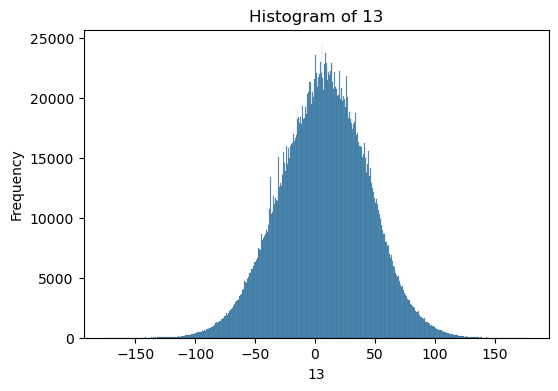

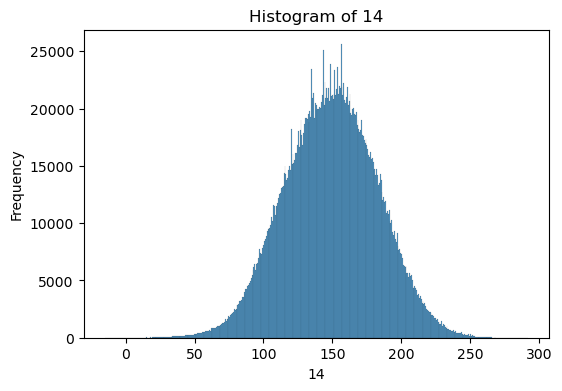

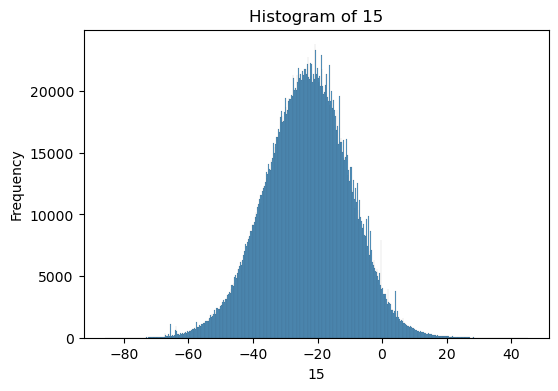

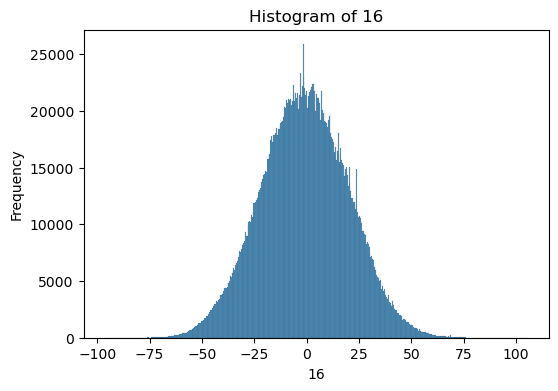

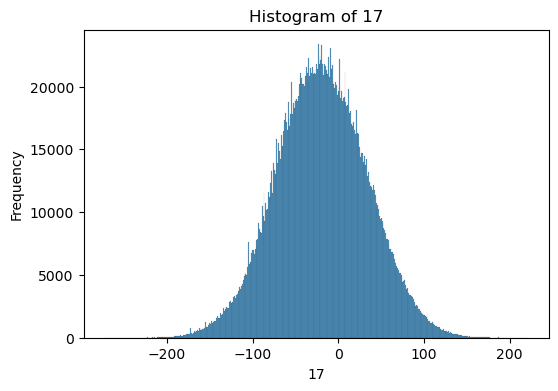

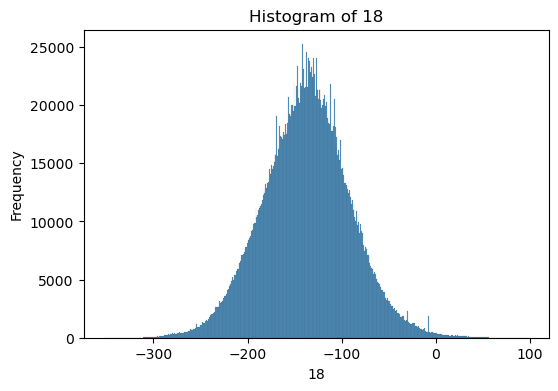

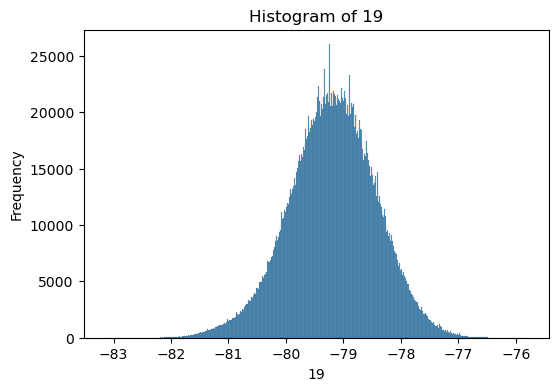

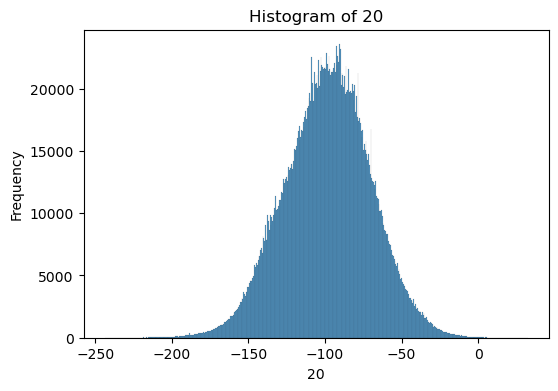

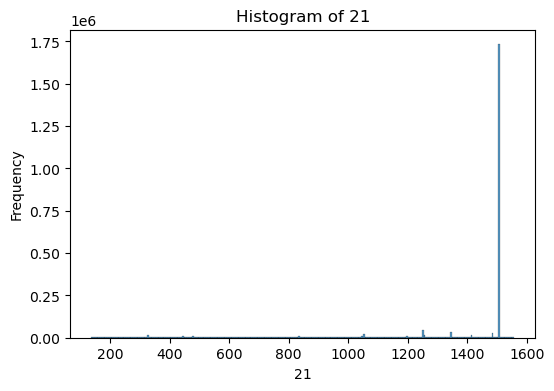

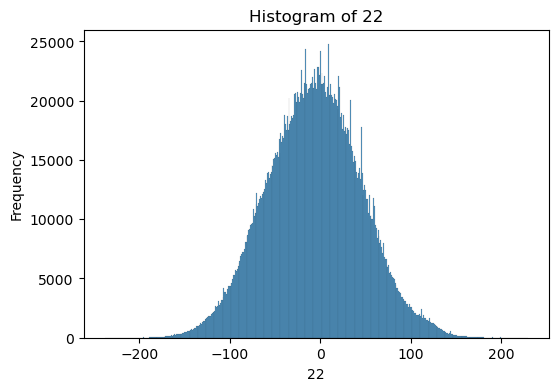

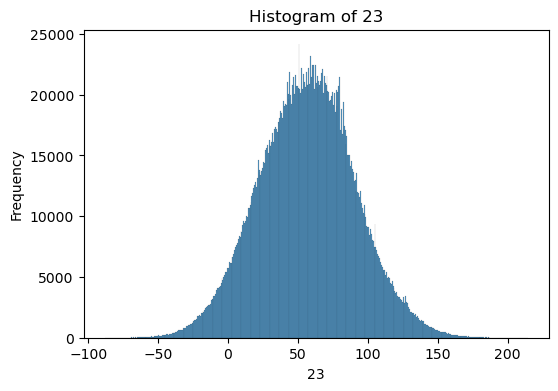

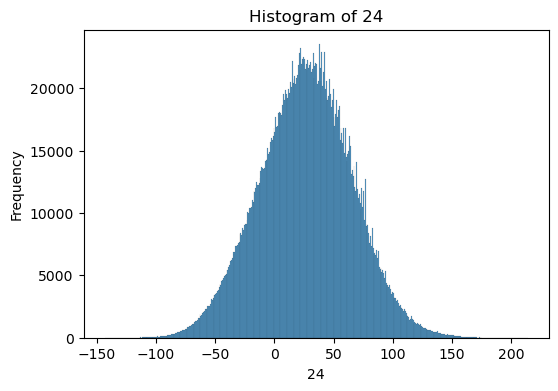

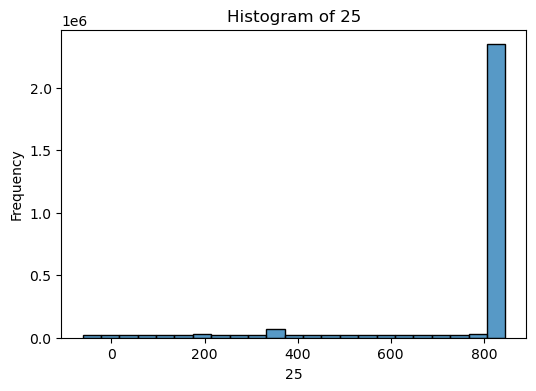

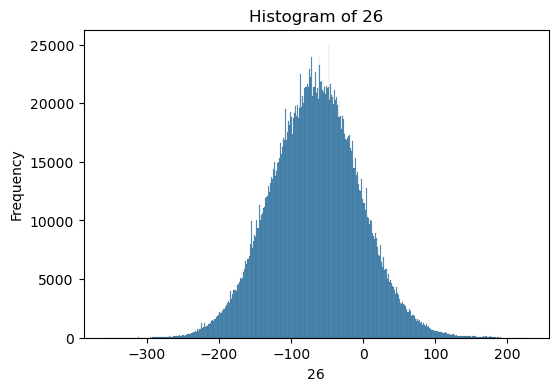

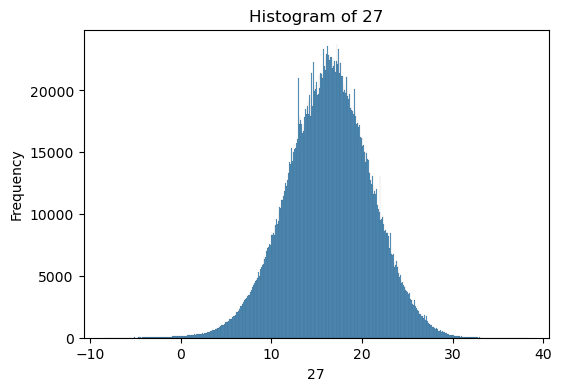

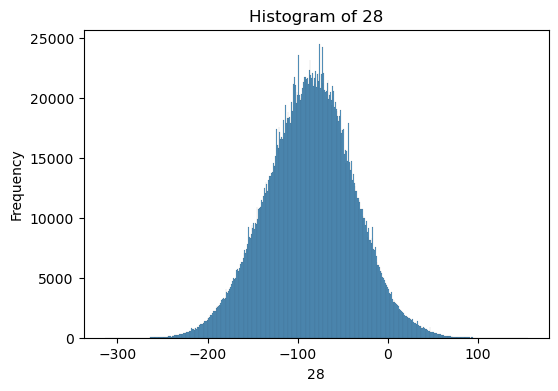

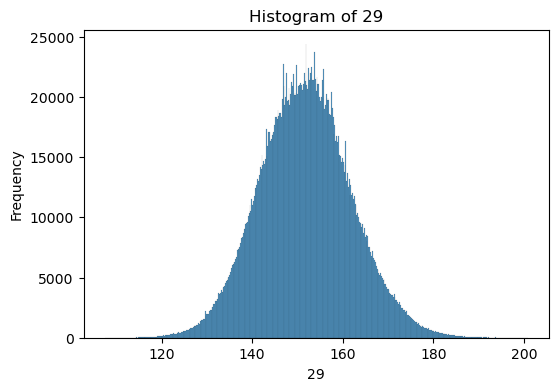

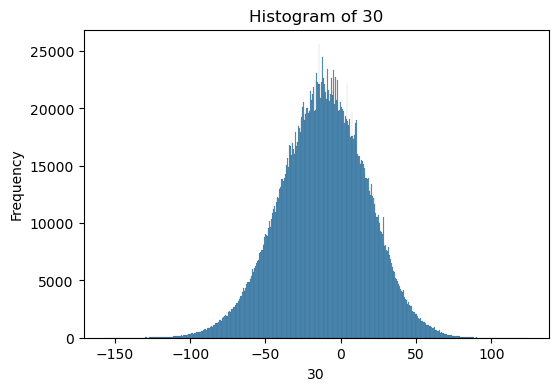

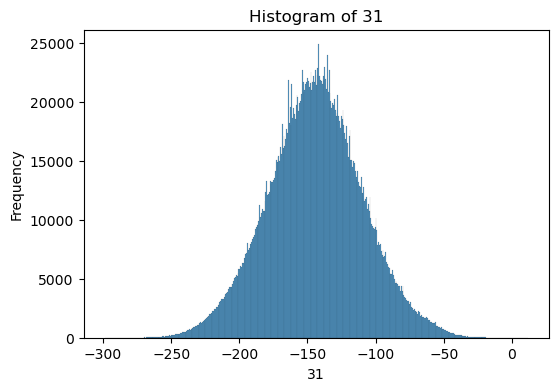

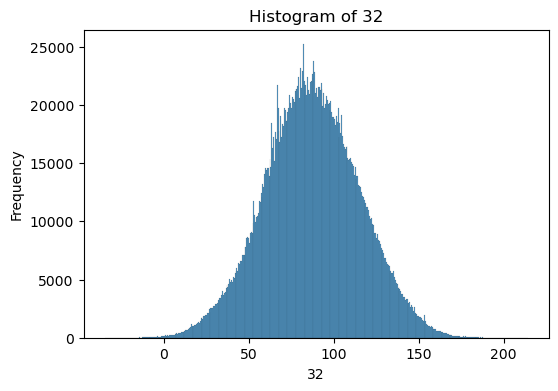

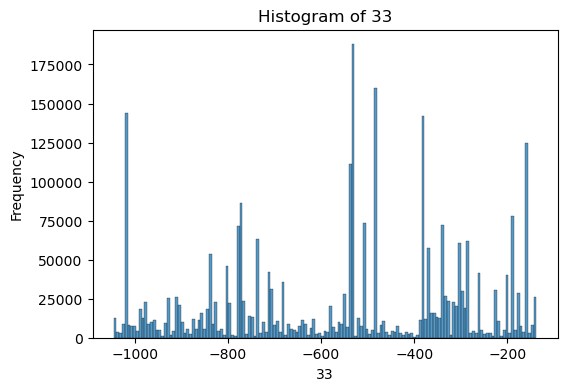

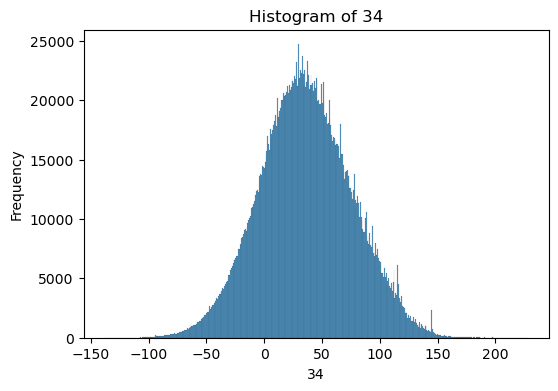

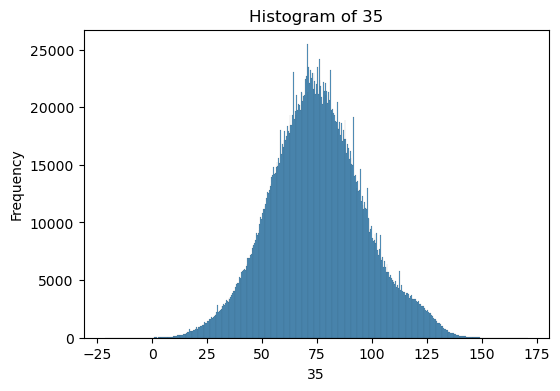

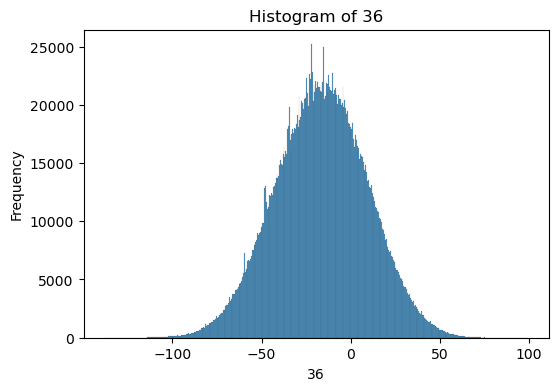

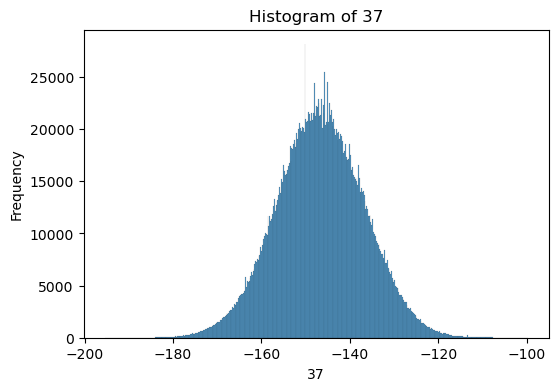

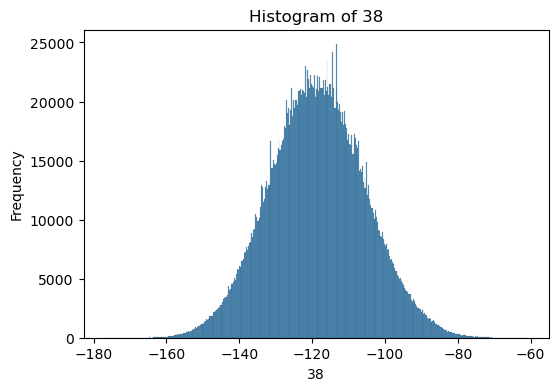

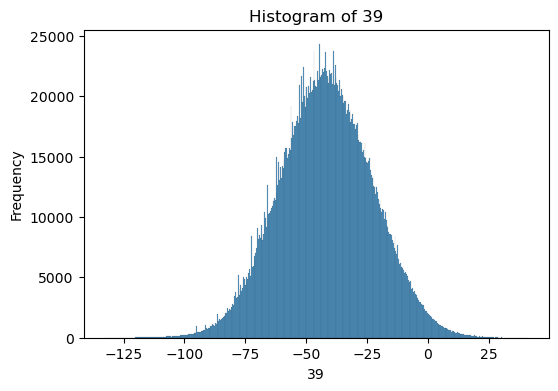

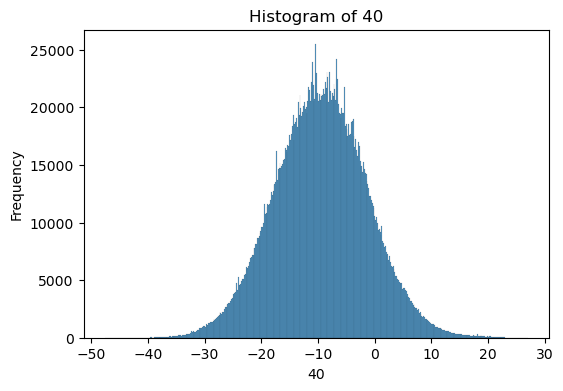

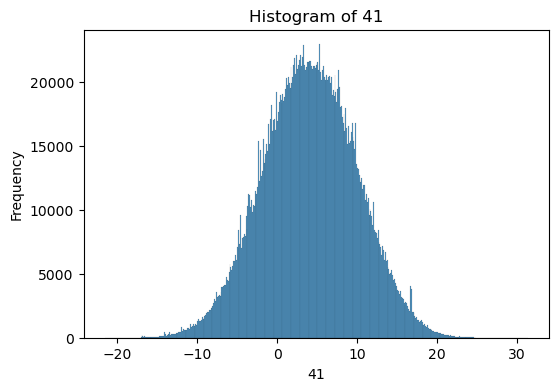

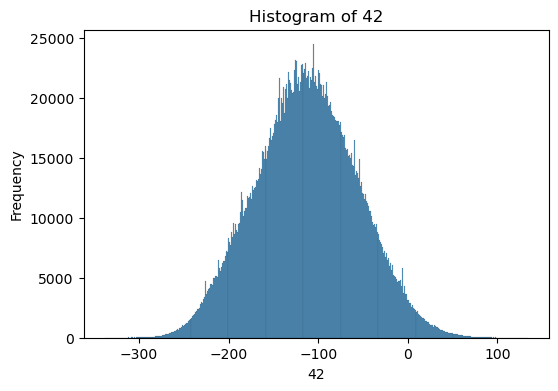

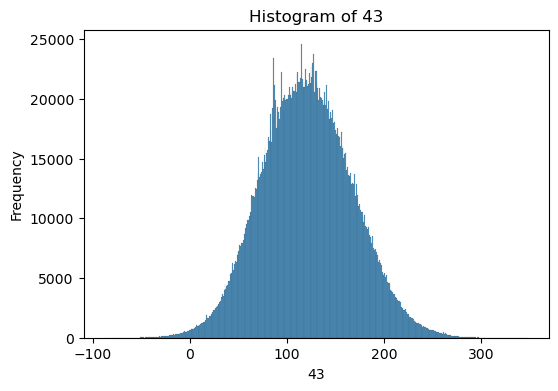

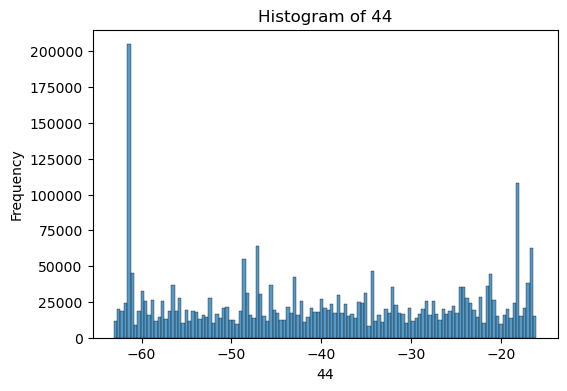

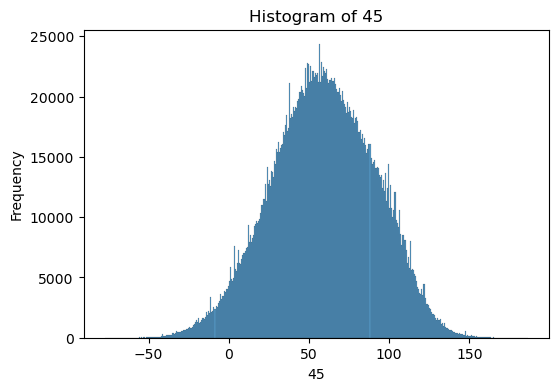

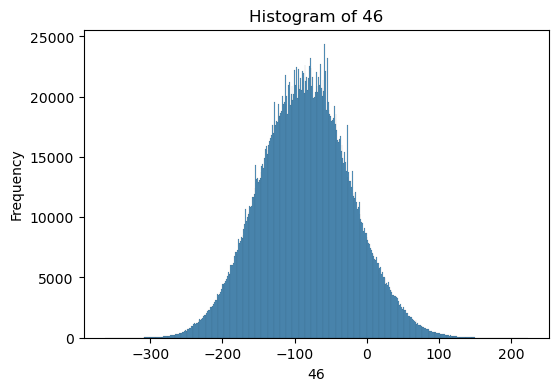

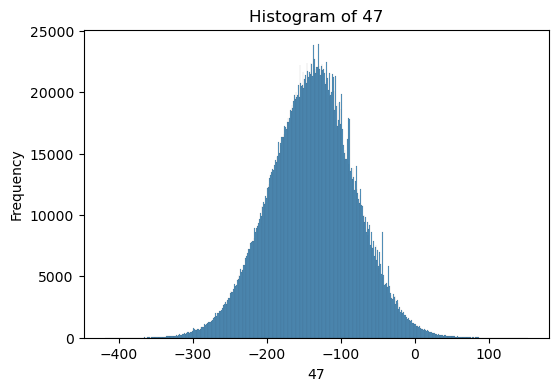

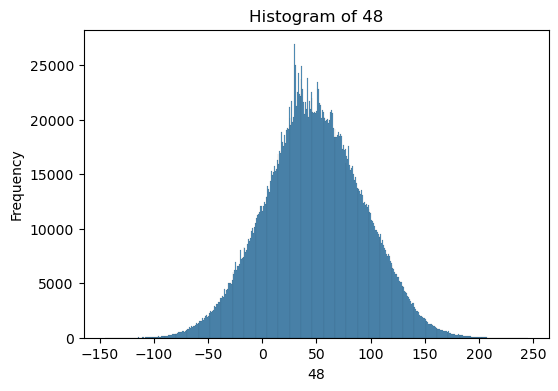

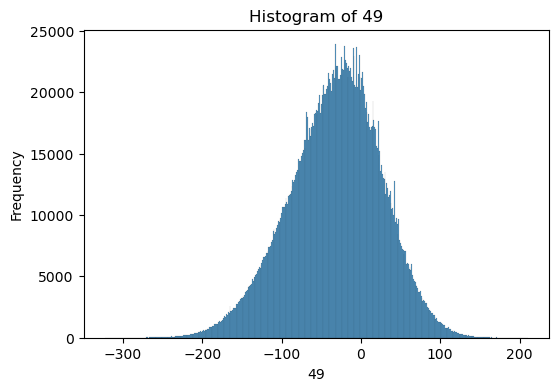

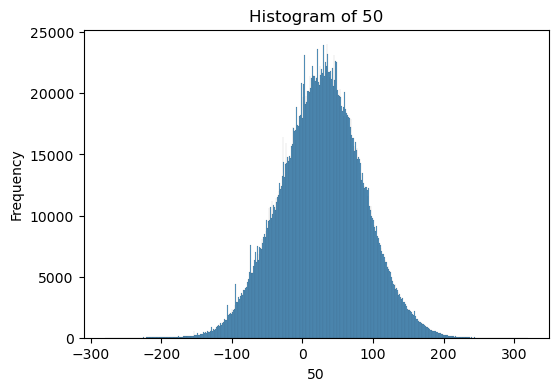

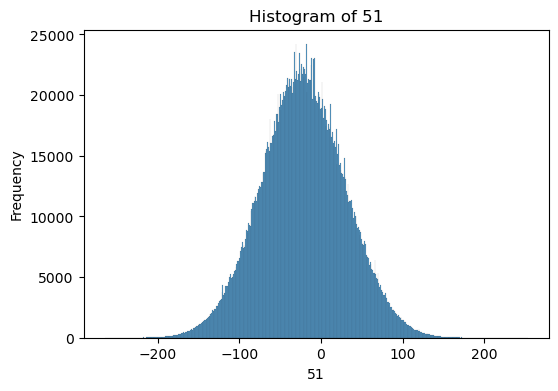

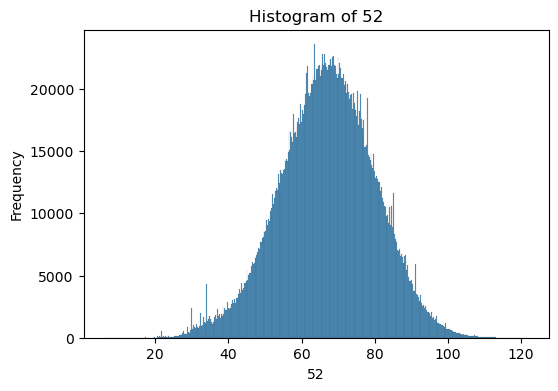

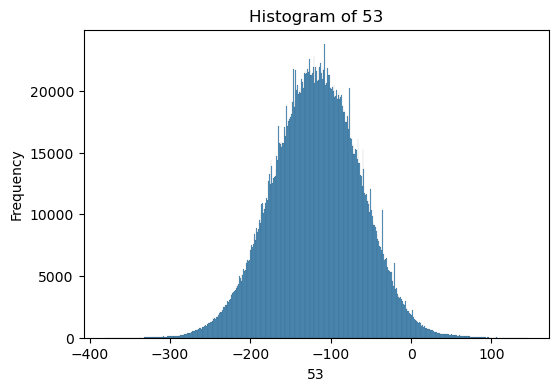

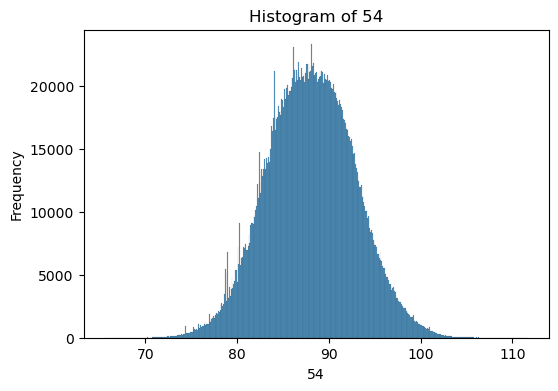

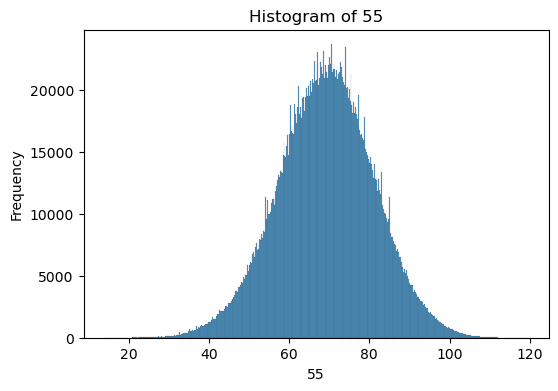

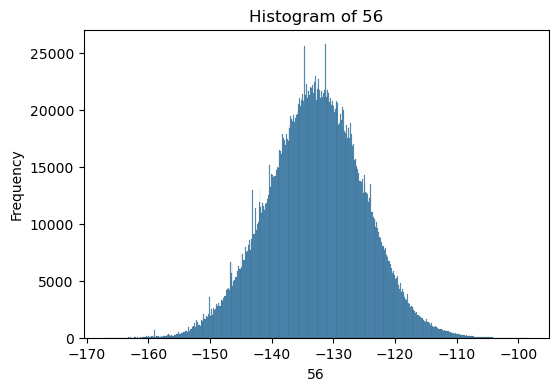

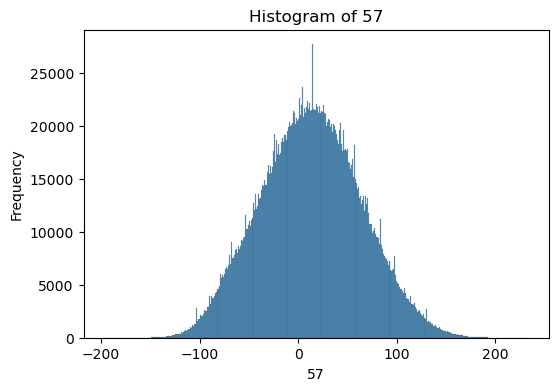

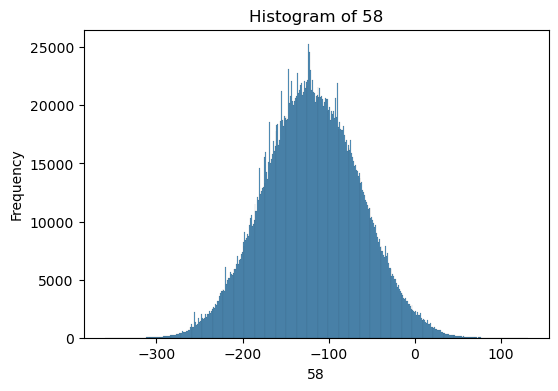

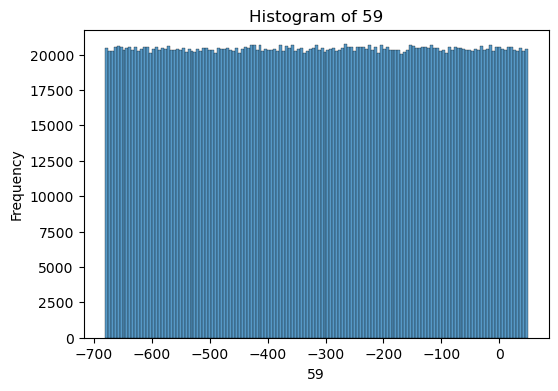

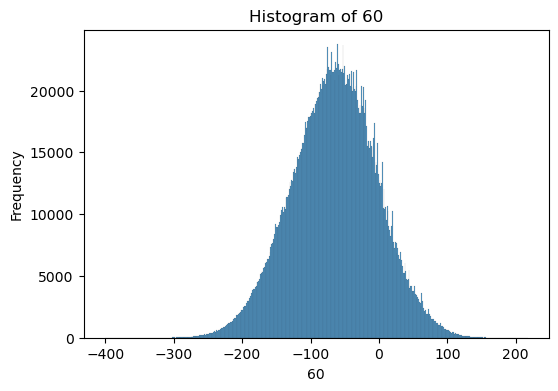

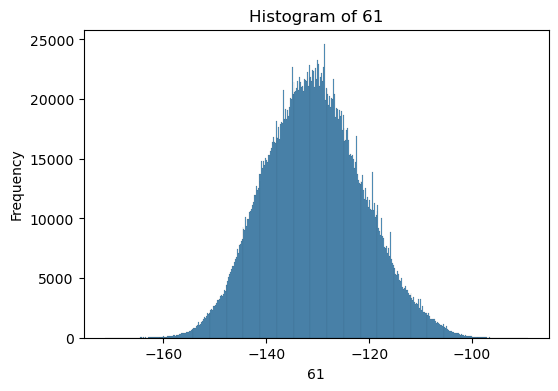

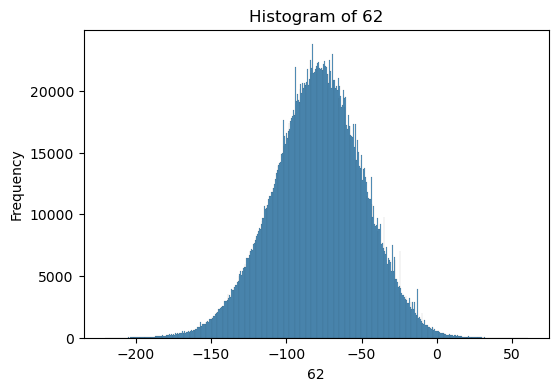

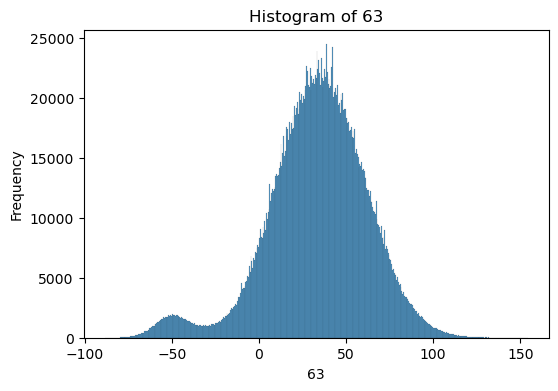

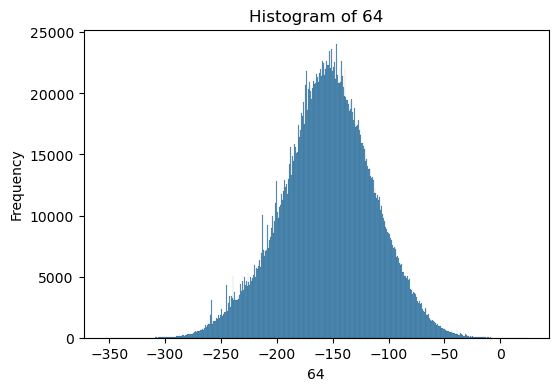

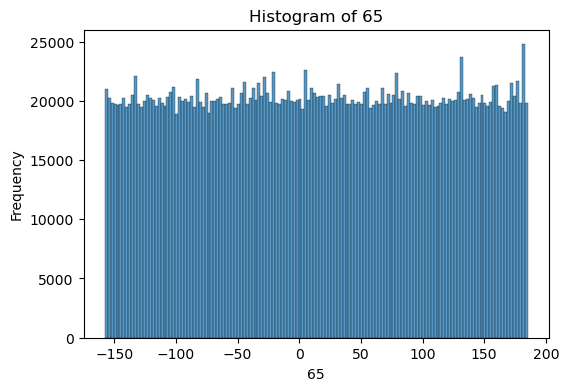

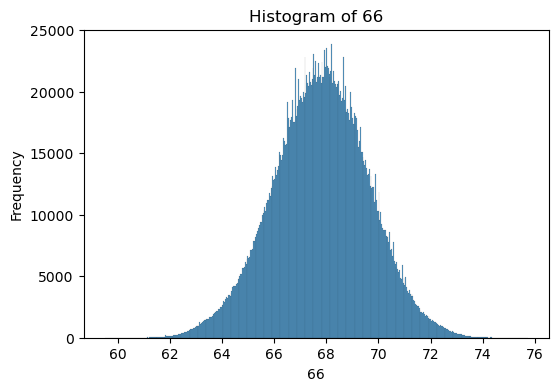

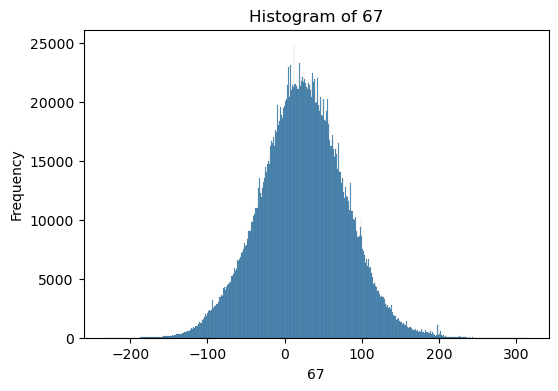

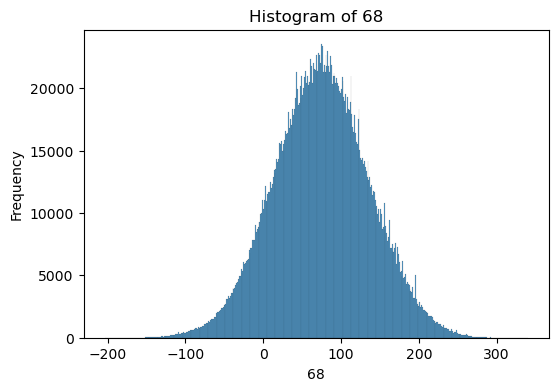

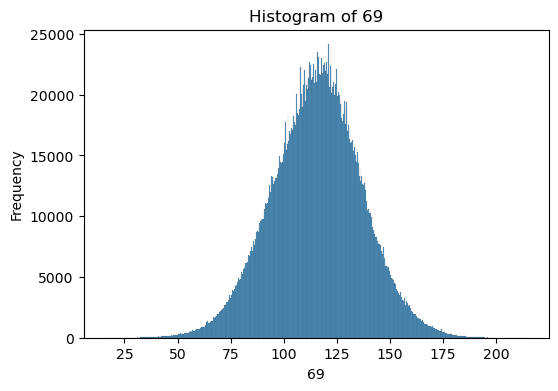

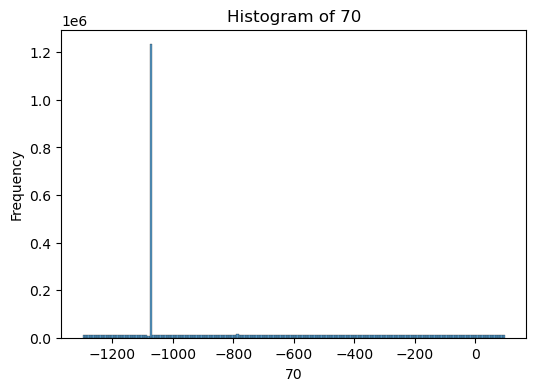

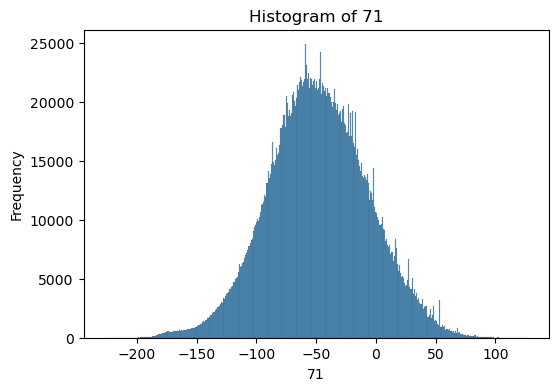

KeyError: 'Target'

<Figure size 600x400 with 0 Axes>

In [18]:
%%time
for column in df_train.columns:
    plt.figure(figsize=(6, 4))  # Задайте размер графика по желанию
    sns.histplot(df_base[column])  # Используйте sns.histplot для построения гистограммы с ядерной оценкой плотности
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Большинство столбцов имеют нормальное распределение. Некоторые столбцы, в обоих датасетах, имеют ненормальное распределение, это столбцы '6','21','25','33','44','59','65','70'.   
Для улучшения дальнейшего исследования удалим эти столбцы. Предварительно отмасштабируем данные.

Для дальнейшего использования тренировочного датасета, разделим датасет на признаки и таргет.

In [19]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Так как все наши столбцы имеют численные значения. то для дальнейшего исследования необходимо их отмасштабировать. Для этого используем StandardScaler. Отмасштабируем на датасете df_base и применим его к датасетам df_base и df_train

In [20]:
scaler = StandardScaler()
df_base_sc = scaler.fit_transform(df_base)

In [21]:
df_train_sc = scaler.transform(df_train)

Переведём отмасштабированные данные в датасеты

In [22]:
scaled_df_base = pd.DataFrame(df_base_sc, columns=df_base.columns, index=df_base.index)

In [23]:
scaled_df_base.drop(columns=['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

In [24]:
scaled_df_base.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,0.373663,-0.435627,0.884544,0.457647,...,0.006792,-0.847513,1.189049,0.190524,0.073589,-2.262493,-0.510438,0.293004,-0.014051,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,-0.871900,-0.623903,1.098487,0.044024,...,1.221724,-1.871023,-1.272135,0.270119,-0.073569,0.225102,0.014491,1.711283,0.059848,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,0.654489,0.828686,0.619635,0.055584,...,-0.586374,-0.417020,0.086191,0.440159,-1.269686,-1.220546,0.773022,0.099669,0.048521,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.840347,-0.259958,0.182763,0.831647,...,-0.394438,-1.949926,0.274980,-1.372853,0.184217,-0.871349,-0.797073,1.014714,0.090076,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,0.386656,-0.238677,-0.191508,0.786741,...,-0.570116,0.559135,0.716557,0.808178,-0.110496,-0.562342,-0.470720,-0.157210,0.920175,1.152406


In [25]:
scaled_df_train = pd.DataFrame(df_train_sc, columns=df_train.columns, index=df_train.index)

In [26]:
scaled_df_train.drop(columns=['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

In [27]:
scaled_df_train.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-0.193435,-0.179583,-0.866975,1.274319,-0.024410,-1.035388,0.197184,-0.200786,0.906575,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,-1.538329,0.193777,0.246358,-0.826778,...,1.382837,-0.704733,1.254600,-0.991073,0.075152,0.207972,0.028031,0.244774,0.709459,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,-0.791080,0.328335,1.352615,1.362356,...,-0.126222,-0.894063,0.886224,1.548929,-0.348054,-0.978114,-0.092956,2.240614,0.300576,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.916179,0.050167,1.834418,-0.081019,...,-1.416759,-0.055445,0.573141,0.388351,0.227494,-2.007464,1.491032,0.133987,0.128028,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.399148,0.355099,-0.326947,0.863249,...,-1.005156,2.855665,0.336621,0.406133,-1.001615,-0.474647,0.341715,0.043401,-1.090276,0.638160


## Использование библиотеки FAISS

### Подбор индекса

Зададим и настроим индекс Faiss для работы с векторами. Количество признаков зададим по количеству столбцов в датасете. Количество кластеров примем 500.

In [28]:
dims = scaled_df_base.shape[1]
n_cells = 500

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Обучим индекс idx_l2 с использованием первых 100 000 строк данных из scaled_df_base

In [29]:
idx_l2.train(np.ascontiguousarray(scaled_df_base.values[:100000, :]).astype('float32'))

Добавим данные из scaled_df_base в индекс idx_l2

In [30]:
idx_l2.add(np.ascontiguousarray(scaled_df_base.values).astype('float32'))

In [31]:
# создадим словарь base_index
base_index = {k: v for k, v in enumerate(scaled_df_base.index.to_list())}

### Поиск ближайших соседей

Проведём поиск ближайших соседей для датасета scaled_df_train и подберём 5 ближайших соседей, затем просчитаем accuracy по совпадению с индексами из scaled_df_base

Зададим число кластеров, которые индекс будет исследовать при выполнении запроса на поиск похожих векторов.

In [32]:
idx_l2.nprobe=50

Выполним поиск расстояний и индексов для 5 ближайших соседей

In [33]:
%%time
r, idx_t = idx_l2.search(np.ascontiguousarray(scaled_df_train.values).astype('float32'), 5)

Wall time: 5min 22s


Рассчитаем accuracy

In [34]:
%%time
acc = 0
for target, el in zip(targets.values.tolist(), idx_t.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx_t))

70.708
Wall time: 334 ms


Аccuracy чуть больше 70% - это хороший результат.    
Попробуем в качестве ранжирующей модели CatBoostClassifier, проверим удастся ли нам улучшить метрику.

## Ранжирующая модель

В качестве ранжирующей модели будем использовать CatBoost. Объединим массивы признаков из 2х датасетов base и train, добавим таргет в виде (1,0), если столбец 'Target' будет равен Id в датасете scaled_df_base. Получим бинарную классификацию. Затем обучим её и найдем accuracy@5.  
Поиск лучших 5 соседей будем проводить после поиска 30 лучших соседей в Faiss

In [35]:
k=30

In [36]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(scaled_df_train.values).astype('float32'), k)

Wall time: 5min 7s


Заменим числовые значения в idx на соответствующие им элементы из словаря base_index

In [37]:
idx = np.array([[base_index[_] for _ in el] for el in idx], dtype=object)

In [38]:
# добавим таргет (1,0)
targets_t = np.array([[1 if x == target else 0 for x in el] for el, target in zip(idx.tolist(), targets.values.tolist())])
targets_t = targets_t.reshape(-1, 1)

Выведем соответствующие индексы, указанные в idx

In [39]:
base_features = scaled_df_base.loc[idx.flatten()].values
train_features = scaled_df_train.values

Размножим массив из датасета scaled_df_train

In [40]:
repeated_object = np.repeat(train_features, k, axis=0)

Объединим всё в один массив, который будет служить в качестве признаков для нашей модели

In [41]:
rang_features = np.hstack((base_features, repeated_object))

Признаки и таргет подготовили, переходим к обучению модели.

In [42]:
# разбивка на выборки
X_train, X_test, y_train, y_test = train_test_split(rang_features, targets_t, test_size=0.2, random_state=12345)

In [43]:
%%time
# обучение модели
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.5369020	test: 0.5369143	best: 0.5369143 (0)	total: 1.16s	remaining: 9m 39s
100:	learn: 0.0804320	test: 0.0799092	best: 0.0799092 (100)	total: 53.6s	remaining: 3m 31s
200:	learn: 0.0709193	test: 0.0708112	best: 0.0708112 (200)	total: 1m 43s	remaining: 2m 33s
300:	learn: 0.0670088	test: 0.0672860	best: 0.0672860 (300)	total: 2m 29s	remaining: 1m 38s
400:	learn: 0.0646052	test: 0.0652402	best: 0.0652402 (400)	total: 3m 15s	remaining: 48.4s
499:	learn: 0.0629404	test: 0.0639546	best: 0.0639546 (499)	total: 3m 59s	remaining: 0us

bestTest = 0.06395457001
bestIteration = 499

Wall time: 5min 20s


In [44]:
# получаем предсказания
predictions = model.predict(X_test)

In [45]:
# получаем вероятности для класса 1
probabilities = model.predict_proba(X_test)[:, 1]

In [46]:
# создаем список индексов для отслеживания
indexes = np.arange(len(probabilities))

In [47]:
# отсортируем вероятности и индексы с сохранением порядка
sorted_indexes = indexes[np.argsort(probabilities)[::-1]]

In [48]:
# выберем топ 5 вероятностей и соответствующие индексы
top_5_probabilities = probabilities[sorted_indexes[:5]]
top_5_indexes = sorted_indexes[:5]

In [49]:
top_5_indexes

array([208473, 404974, 468253, 258112, 120291])

Перейдём к подсчёту метрики

In [50]:
# преобразуем строковые значения в массиве targets для сравнения
targets_array = targets.str.extract('(\d+)', expand=False).astype(int)

In [51]:
targets_array

Id
0-query         675816
1-query         366656
2-query        1447819
3-query        1472602
4-query         717819
                ...   
99995-query     811868
99996-query    1460772
99997-query    2366140
99998-query       9252
99999-query    2769109
Name: Target, Length: 100000, dtype: int32

In [52]:
acc = sum(target in [base_index[r] for r in top_5_indexes.tolist()] for target in targets_array.tolist())
accuracy = (acc / len(top_5_indexes)) * 100
print(accuracy)

0.0


Модель CatBoostClassifier, к сожалению, не дала нам нужного результата.   
Для предсказаний ближайших соседей для датасета Validation будем использовать библиотеку FAISS

## Поиск ближайших соседей на датасете Validation

Выгрузим датасет Validation и датасет с правильными ответами для оценки accuracy. Предварительно отмасштабируем данные в датасете Validation

In [53]:
# выгружаем датасет
df_valid = pd.read_csv('//192.168.2.105/consilio/DFS Folders/Users/s.gayvazov/Мои документы/Практикум/Мастерская_2/validation.csv',
                       index_col=0)

In [54]:
# выгружаем датасет
df_valid_answer = pd.read_csv('//192.168.2.105/consilio/DFS Folders/Users/s.gayvazov/Мои документы/Практикум/Мастерская_2/validation_answer.csv')

In [55]:
df_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [56]:
df_valid_answer.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


In [57]:
df_valid_sc = scaler.transform(df_valid)

In [58]:
scaled_df_valid = pd.DataFrame(df_valid_sc, columns=df_valid.columns, index=df_valid.index)

In [59]:
scaled_df_valid.drop(columns=['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

Зададим таргет

In [60]:
target_valid = df_valid_answer['Expected']

Перейдём к поиску ближайших соседей и подсчёту метрики accuracy

In [61]:
%%time
r_valid, idx_valid = idx_l2.search(np.ascontiguousarray(scaled_df_valid.values).astype('float32'), 5)

Wall time: 5min 11s


In [62]:
%%time
acc = 0
for target, el in zip(target_valid.values.tolist(), idx_valid.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx_valid))

70.622
Wall time: 366 ms


На датасете Validation accuracy получилась более 70% - это хороший результат.

## Вывод


Мы провели исследование на реальных данных для разработки рекомендательной модели для поиска ближайших соседей. Мы имели базовый, тренировочный и валидационный(тестовый) датасеты. Признаки в этих датасетах были закодированы числовыми значениями.   
Обработка данных показала, что дубликаты и пропуски отсутствуют, масмштабирование провели с помощью StandardScaler.   
С помощью библиотеки FAISS подобрали 5 ближайших соседей из базового датасета для тренировочного датасета, метрика accuracy составила 70,8%.  
Затем опробовали в качестве ранжирующей модели - CatBoostClassifier, к сожалению, улучшения метрики данная модель не показала.  На валидационном (тестовом) датасете опробовали библиотеку FAISS и получили хорошее значение метрики accuracy - более 70%. Эту модель можно использовать в качестве рекомендательной системы для целей Заказчика.